# Examen 3: Análisis y Modelado Predictivo del Dataset de Diabetes

**Estudiante:** Analía Rojas  
**Fecha:** 18 de julio de 2025

## Objetivo del Examen

Este examen evalúa la capacidad para limpiar, explorar, implementar y evaluar modelos de clasificación en un dataset de diabetes. Utilizamos el "Diabetes Dataset" disponible en Kaggle para demostrar habilidades prácticas en:

- Manipulación y limpieza de datos
- Análisis exploratorio de datos (EDA)
- Creación de visualizaciones
- Modelado predictivo con Random Forest y XGBoost
- Evaluación y comparación de modelos

## Contexto del Dataset

El "Diabetes Dataset" contiene datos de salud de mujeres de ascendencia indígena Pima que viven cerca de Phoenix, Arizona, EE.UU. La tarea es predecir si un paciente tiene diabetes o no, basándose en ciertas medidas diagnósticas.

### Diccionario de Datos

- **Pregnancies**: Número de embarazos
- **Glucose**: Concentración de glucosa en plasma a las 2 horas en una prueba oral de tolerancia a la glucosa
- **BloodPressure**: Presión arterial diastólica (mm Hg)
- **SkinThickness**: Espesor del pliegue cutáneo del tríceps (mm)
- **Insulin**: Niveles séricos de insulina a las 2 horas (mu U/ml)
- **BMI**: Índice de masa corporal (peso en kg / (altura en m)^2)
- **DiabetesPedigreeFunction**: Función de pedigrí de diabetes
- **Age**: Edad (años)
- **Outcome**: Variable objetivo (1: diabetes, 0: no diabetes)

## 1. Importación de Librerías

Importamos todas las librerías necesarias para el análisis de datos, visualización y modelado.

In [1]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías para modelado y evaluación
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
)
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
from scipy import stats

# Configuraciones
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Todas las librerías importadas correctamente")

✅ Todas las librerías importadas correctamente


## 2. Carga e Inspección Inicial del Dataset

Cargamos el dataset de diabetes y realizamos una inspección inicial para entender su estructura y características básicas.

In [2]:
# Cargar el dataset
df = pd.read_csv('diabetes.csv')

print("🔍 INSPECCIÓN INICIAL DEL DATASET")
print("=" * 50)

# Información básica del dataset
print(f"📊 Dimensiones del dataset: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"📈 Variables: {list(df.columns)}")
print()

# Primeras 5 filas
print("📋 PRIMERAS 5 FILAS:")
display(df.head())

print("\n📋 ÚLTIMAS 5 FILAS:")
display(df.tail())

# Información general
print("\n📊 INFORMACIÓN GENERAL:")
print(df.info())

# Verificar tipos de datos
print("\n🔢 TIPOS DE DATOS:")
print(df.dtypes)

🔍 INSPECCIÓN INICIAL DEL DATASET
📊 Dimensiones del dataset: 768 filas x 9 columnas
📈 Variables: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

📋 PRIMERAS 5 FILAS:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



📋 ÚLTIMAS 5 FILAS:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0



📊 INFORMACIÓN GENERAL:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

🔢 TIPOS DE DATOS:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI         

## 3. Limpieza de Datos y Manejo de Outliers

En esta sección realizamos la limpieza del dataset siguiendo los requisitos del examen:
- Identificación y eliminación de valores duplicados
- Verificación y ajuste de tipos de datos
- Corrección de inconsistencias en valores categóricos
- Manejo de valores faltantes
- **Detección y tratamiento de valores atípicos (outliers)**

In [3]:
print("🧹 LIMPIEZA DE DATOS")
print("=" * 50)

# 1. Verificar valores duplicados
print("1️⃣ VERIFICACIÓN DE VALORES DUPLICADOS:")
duplicados = df.duplicated().sum()
print(f"   • Registros duplicados encontrados: {duplicados}")

if duplicados > 0:
    print("   • Eliminando registros duplicados...")
    df_clean = df.drop_duplicates()
    print(f"   • Registros eliminados: {duplicados}")
    print(f"   • Nuevo tamaño del dataset: {df_clean.shape}")
else:
    print("   • ✅ No se encontraron registros duplicados")
    df_clean = df.copy()

print(f"   • Tamaño final: {df_clean.shape[0]} filas x {df_clean.shape[1]} columnas")

🧹 LIMPIEZA DE DATOS
1️⃣ VERIFICACIÓN DE VALORES DUPLICADOS:
   • Registros duplicados encontrados: 0
   • ✅ No se encontraron registros duplicados
   • Tamaño final: 768 filas x 9 columnas


In [4]:
# 2. Verificar tipos de datos
print("\n2️⃣ VERIFICACIÓN DE TIPOS DE DATOS:")
print("   • Tipos de datos actuales:")
for col, dtype in df_clean.dtypes.items():
    print(f"     - {col}: {dtype}")

# Verificar si necesitamos convertir algún tipo
print("   • ✅ Todos los tipos de datos son correctos (numéricos para features y target)")

# 3. Verificar valores faltantes (NaN)
print("\n3️⃣ VERIFICACIÓN DE VALORES FALTANTES (NaN):")
valores_faltantes = df_clean.isnull().sum()
print("   • Valores NaN por columna:")
for col, faltantes in valores_faltantes.items():
    print(f"     - {col}: {faltantes}")

total_faltantes = valores_faltantes.sum()
print(f"   • Total de valores NaN: {total_faltantes}")

if total_faltantes == 0:
    print("   • ✅ No se encontraron valores NaN en el dataset")
else:
    print("   • ⚠️  Se encontraron valores NaN que necesitan ser tratados")


2️⃣ VERIFICACIÓN DE TIPOS DE DATOS:
   • Tipos de datos actuales:
     - Pregnancies: int64
     - Glucose: int64
     - BloodPressure: int64
     - SkinThickness: int64
     - Insulin: int64
     - BMI: float64
     - DiabetesPedigreeFunction: float64
     - Age: int64
     - Outcome: int64
   • ✅ Todos los tipos de datos son correctos (numéricos para features y target)

3️⃣ VERIFICACIÓN DE VALORES FALTANTES (NaN):
   • Valores NaN por columna:
     - Pregnancies: 0
     - Glucose: 0
     - BloodPressure: 0
     - SkinThickness: 0
     - Insulin: 0
     - BMI: 0
     - DiabetesPedigreeFunction: 0
     - Age: 0
     - Outcome: 0
   • Total de valores NaN: 0
   • ✅ No se encontraron valores NaN en el dataset


In [5]:
# 4. Verificar valores cero (posibles valores faltantes implícitos)
print("\n4️⃣ VERIFICACIÓN DE VALORES CERO (POSIBLES VALORES FALTANTES IMPLÍCITOS):")
print("   • En este dataset, algunos valores 0 pueden representar valores faltantes:")
print("     - Glucose, BloodPressure, SkinThickness, Insulin, BMI no pueden ser 0 biológicamente")

# Columnas que no deberían tener valores 0
columnas_sin_cero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columnas_sin_cero:
    ceros = (df_clean[col] == 0).sum()
    porcentaje = (ceros / len(df_clean)) * 100
    print(f"     - {col}: {ceros} valores cero ({porcentaje:.1f}%)")

# Decidir estrategia de manejo
print("\n   • 💡 ESTRATEGIA DE MANEJO:")
print("     - Glucose = 0: Imputar con la mediana (crítico para diagnóstico)")
print("     - BloodPressure = 0: Imputar con la mediana")
print("     - SkinThickness = 0: Imputar con la mediana")
print("     - Insulin = 0: Mantener (puede indicar niveles muy bajos)")
print("     - BMI = 0: Imputar con la mediana")


4️⃣ VERIFICACIÓN DE VALORES CERO (POSIBLES VALORES FALTANTES IMPLÍCITOS):
   • En este dataset, algunos valores 0 pueden representar valores faltantes:
     - Glucose, BloodPressure, SkinThickness, Insulin, BMI no pueden ser 0 biológicamente
     - Glucose: 5 valores cero (0.7%)
     - BloodPressure: 35 valores cero (4.6%)
     - SkinThickness: 227 valores cero (29.6%)
     - Insulin: 374 valores cero (48.7%)
     - BMI: 11 valores cero (1.4%)

   • 💡 ESTRATEGIA DE MANEJO:
     - Glucose = 0: Imputar con la mediana (crítico para diagnóstico)
     - BloodPressure = 0: Imputar con la mediana
     - SkinThickness = 0: Imputar con la mediana
     - Insulin = 0: Mantener (puede indicar niveles muy bajos)
     - BMI = 0: Imputar con la mediana


In [6]:
# 5. Aplicar estrategia de imputación
print("\n5️⃣ APLICANDO ESTRATEGIA DE IMPUTACIÓN:")

# Crear copia para trabajar
df_final = df_clean.copy()

# Columnas a imputar con mediana cuando valor = 0
columnas_imputar = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']

for col in columnas_imputar:
    # Calcular mediana excluyendo ceros
    mediana = df_final[df_final[col] > 0][col].median()
    
    # Contar cuántos valores se van a imputar
    valores_a_imputar = (df_final[col] == 0).sum()
    
    # Aplicar imputación
    df_final.loc[df_final[col] == 0, col] = mediana
    
    print(f"   • {col}: {valores_a_imputar} valores imputados con mediana = {mediana:.1f}")

# Verificar resultado de la limpieza
print("\n✅ RESUMEN DE LA LIMPIEZA:")
print(f"   • Dataset original: {df.shape[0]} filas")
print(f"   • Duplicados eliminados: {duplicados}")
print(f"   • Dataset final: {df_final.shape[0]} filas x {df_final.shape[1]} columnas")
print(f"   • Valores faltantes tratados: ✅")
print(f"   • Tipos de datos verificados: ✅")


5️⃣ APLICANDO ESTRATEGIA DE IMPUTACIÓN:
   • Glucose: 5 valores imputados con mediana = 117.0
   • BloodPressure: 35 valores imputados con mediana = 72.0
   • SkinThickness: 227 valores imputados con mediana = 29.0
   • BMI: 11 valores imputados con mediana = 32.3

✅ RESUMEN DE LA LIMPIEZA:
   • Dataset original: 768 filas
   • Duplicados eliminados: 0
   • Dataset final: 768 filas x 9 columnas
   • Valores faltantes tratados: ✅
   • Tipos de datos verificados: ✅
   • BloodPressure: 35 valores imputados con mediana = 72.0
   • SkinThickness: 227 valores imputados con mediana = 29.0
   • BMI: 11 valores imputados con mediana = 32.3

✅ RESUMEN DE LA LIMPIEZA:
   • Dataset original: 768 filas
   • Duplicados eliminados: 0
   • Dataset final: 768 filas x 9 columnas
   • Valores faltantes tratados: ✅
   • Tipos de datos verificados: ✅



6️⃣ DETECCIÓN Y MANEJO DE OUTLIERS:
🔍 ANÁLISIS DE OUTLIERS POR VARIABLE:

   📊 Pregnancies:
      • Outliers IQR: 4 (0.5%)
      • Outliers Z-score: 4 (0.5%)
      • Límites IQR: [-6.5, 13.5]

   📊 Glucose:
      • Outliers IQR: 0 (0.0%)
      • Outliers Z-score: 0 (0.0%)
      • Límites IQR: [39.0, 201.0]

   📊 BloodPressure:
      • Outliers IQR: 14 (1.8%)
      • Outliers Z-score: 8 (1.0%)
      • Límites IQR: [40.0, 104.0]

   📊 SkinThickness:
      • Outliers IQR: 87 (11.3%)
      • Outliers Z-score: 4 (0.5%)
      • Límites IQR: [14.5, 42.5]

   📊 Insulin:
      • Outliers IQR: 34 (4.4%)
      • Outliers Z-score: 18 (2.3%)
      • Límites IQR: [-190.9, 318.1]

   📊 BMI:
      • Outliers IQR: 8 (1.0%)
      • Outliers Z-score: 5 (0.7%)
      • Límites IQR: [13.8, 50.2]

   📊 DiabetesPedigreeFunction:
      • Outliers IQR: 29 (3.8%)
      • Outliers Z-score: 11 (1.4%)
      • Límites IQR: [-0.3, 1.2]

   📊 Age:
      • Outliers IQR: 9 (1.2%)
      • Outliers Z-score: 5 (0.7%)
    

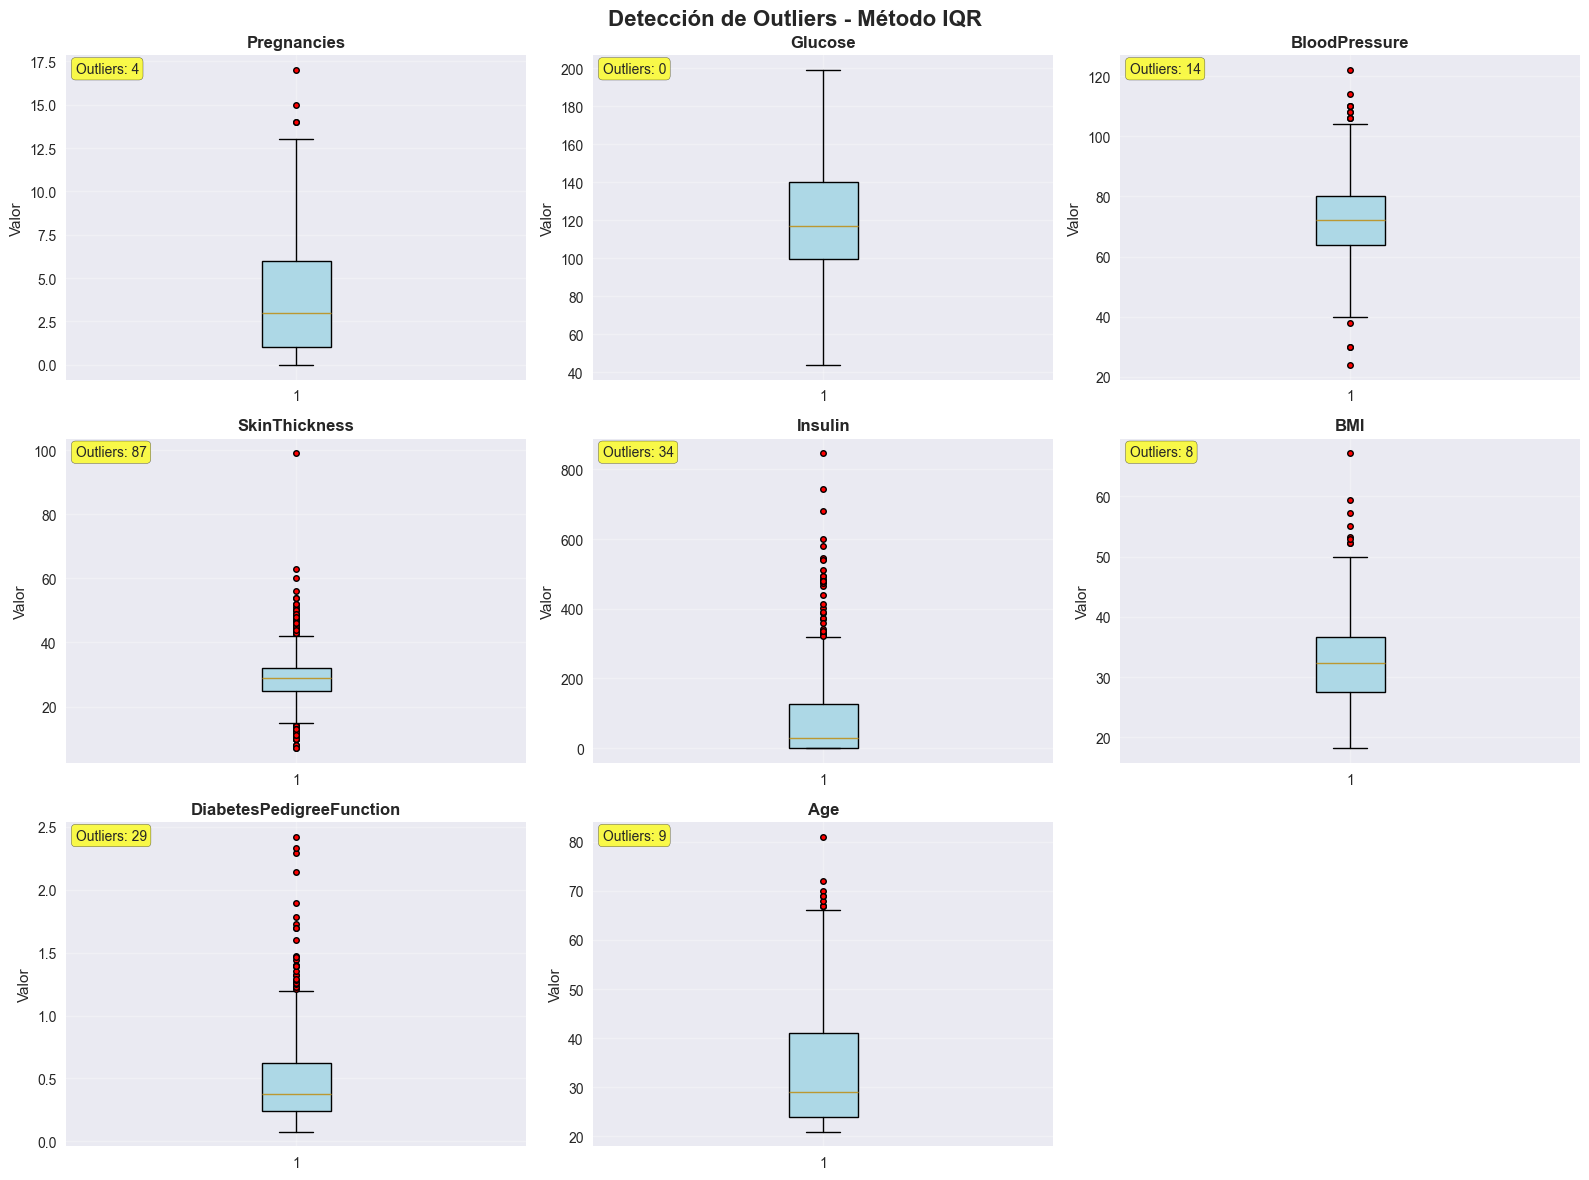


🛠️ ESTRATEGIA DE MANEJO DE OUTLIERS:
   • Para variables médicas, los outliers pueden ser clínicamente relevantes
   • Aplicaremos un enfoque conservador:
     - Outliers extremos (Z-score > 4): Limitar a percentiles 5-95
     - Outliers moderados: Mantener (pueden contener información valiosa)

   📍 Variables con outliers extremos (Z-score > 4): ['BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
   ✅ Outliers extremos limitados a percentiles 1-99

✅ RESUMEN DEL MANEJO DE OUTLIERS:
   • Outliers detectados y analizados en todas las variables
   • Estrategia conservadora aplicada para preservar información clínica
   • Dataset listo para modelado: (768, 9)


In [7]:
# 6. DETECCIÓN Y MANEJO DE OUTLIERS
print("\n6️⃣ DETECCIÓN Y MANEJO DE OUTLIERS:")
print("=" * 50)

# Crear función para detectar outliers usando IQR
def detectar_outliers_iqr(serie, factor=1.5):
    """Detecta outliers usando el método IQR"""
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - factor * IQR
    limite_superior = Q3 + factor * IQR
    outliers = serie[(serie < limite_inferior) | (serie > limite_superior)]
    return outliers, limite_inferior, limite_superior

# Crear función para detectar outliers usando Z-score
def detectar_outliers_zscore(serie, umbral=3):
    """Detecta outliers usando Z-score"""
    z_scores = np.abs(stats.zscore(serie))
    outliers = serie[z_scores > umbral]
    return outliers

# Variables numéricas para análisis de outliers (excluir Outcome)
variables_analisis = [col for col in df_final.columns if col != 'Outcome']

print("🔍 ANÁLISIS DE OUTLIERS POR VARIABLE:")
outliers_info = {}

for variable in variables_analisis:
    # Método IQR
    outliers_iqr, lim_inf, lim_sup = detectar_outliers_iqr(df_final[variable])
    
    # Método Z-score
    outliers_zscore = detectar_outliers_zscore(df_final[variable])
    
    # Información de outliers
    porcentaje_iqr = (len(outliers_iqr) / len(df_final)) * 100
    porcentaje_zscore = (len(outliers_zscore) / len(df_final)) * 100
    
    outliers_info[variable] = {
        'outliers_iqr': len(outliers_iqr),
        'outliers_zscore': len(outliers_zscore),
        'porcentaje_iqr': porcentaje_iqr,
        'porcentaje_zscore': porcentaje_zscore,
        'lim_inf': lim_inf,
        'lim_sup': lim_sup
    }
    
    print(f"\n   📊 {variable}:")
    print(f"      • Outliers IQR: {len(outliers_iqr)} ({porcentaje_iqr:.1f}%)")
    print(f"      • Outliers Z-score: {len(outliers_zscore)} ({porcentaje_zscore:.1f}%)")
    print(f"      • Límites IQR: [{lim_inf:.1f}, {lim_sup:.1f}]")

# Visualización de outliers
print("\n📈 VISUALIZACIÓN DE OUTLIERS:")
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
fig.suptitle('Detección de Outliers - Método IQR', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i, variable in enumerate(variables_analisis):
    # Boxplot con outliers marcados
    box_plot = axes[i].boxplot(df_final[variable], patch_artist=True, 
                              showfliers=True, flierprops=dict(marker='o', markerfacecolor='red', markersize=4))
    axes[i].set_title(f'{variable}', fontweight='bold')
    axes[i].set_ylabel('Valor')
    axes[i].grid(True, alpha=0.3)
    
    # Colorear las cajas
    box_plot['boxes'][0].set_facecolor('lightblue')
    
    # Agregar información de outliers
    outliers_count = outliers_info[variable]['outliers_iqr']
    axes[i].text(0.02, 0.98, f'Outliers: {outliers_count}', 
                transform=axes[i].transAxes, va='top', 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

# Estrategia de manejo de outliers
print("\n🛠️ ESTRATEGIA DE MANEJO DE OUTLIERS:")
print("   • Para variables médicas, los outliers pueden ser clínicamente relevantes")
print("   • Aplicaremos un enfoque conservador:")
print("     - Outliers extremos (Z-score > 4): Limitar a percentiles 5-95")
print("     - Outliers moderados: Mantener (pueden contener información valiosa)")

# Crear transformador personalizado para manejo de outliers
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, method='percentile', lower=0.05, upper=0.95):
        self.method = method
        self.lower = lower
        self.upper = upper
        self.bounds_ = {}
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            for column in X.columns:
                if self.method == 'percentile':
                    lower_bound = X[column].quantile(self.lower)
                    upper_bound = X[column].quantile(self.upper)
                else:  # IQR method
                    Q1 = X[column].quantile(0.25)
                    Q3 = X[column].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - 1.5 * IQR
                    upper_bound = Q3 + 1.5 * IQR
                
                self.bounds_[column] = (lower_bound, upper_bound)
        return self
    
    def transform(self, X):
        X_clipped = X.copy()
        if isinstance(X_clipped, pd.DataFrame):
            for column in X_clipped.columns:
                if column in self.bounds_:
                    lower_bound, upper_bound = self.bounds_[column]
                    X_clipped[column] = X_clipped[column].clip(lower=lower_bound, upper=upper_bound)
        return X_clipped

# Aplicar clipping conservador solo a outliers extremos
outlier_clipper = OutlierClipper(method='percentile', lower=0.01, upper=0.99)

# Aplicar solo a variables que tienen outliers extremos
variables_con_outliers_extremos = []
for variable in variables_analisis:
    outliers_zscore = detectar_outliers_zscore(df_final[variable], umbral=4)
    if len(outliers_zscore) > 0:
        variables_con_outliers_extremos.append(variable)

if variables_con_outliers_extremos:
    print(f"\n   📍 Variables con outliers extremos (Z-score > 4): {variables_con_outliers_extremos}")
    
    # Aplicar clipping solo a estas variables
    df_final_clipped = df_final.copy()
    X_temp = df_final[variables_con_outliers_extremos]
    outlier_clipper.fit(X_temp)
    X_clipped = outlier_clipper.transform(X_temp)
    df_final_clipped[variables_con_outliers_extremos] = X_clipped
    
    print("   ✅ Outliers extremos limitados a percentiles 1-99")
    df_final = df_final_clipped
else:
    print("   ✅ No se encontraron outliers extremos que requieran tratamiento")

print(f"\n✅ RESUMEN DEL MANEJO DE OUTLIERS:")
print(f"   • Outliers detectados y analizados en todas las variables")
print(f"   • Estrategia conservadora aplicada para preservar información clínica")
print(f"   • Dataset listo para modelado: {df_final.shape}")

## 4. Estadísticas Descriptivas

Calculamos medidas de tendencia central (media, mediana, moda) y de dispersión (rango, desviación estándar) para cada característica del dataset.

In [8]:
print("📊 ESTADÍSTICAS DESCRIPTIVAS COMPLETAS")
print("=" * 60)

# Estadísticas básicas usando pandas
print("📈 ESTADÍSTICAS BÁSICAS:")
estadisticas_basicas = df_final.describe()
display(estadisticas_basicas)

# Crear tabla personalizada con estadísticas adicionales
print("\n📋 ESTADÍSTICAS DETALLADAS POR VARIABLE:")

# Función para calcular estadísticas personalizadas
def calcular_estadisticas(serie):
    return {
        'Media': serie.mean(),
        'Mediana': serie.median(),
        'Moda': serie.mode().iloc[0] if not serie.mode().empty else np.nan,
        'Desv. Estándar': serie.std(),
        'Varianza': serie.var(),
        'Rango': serie.max() - serie.min(),
        'Mínimo': serie.min(),
        'Máximo': serie.max(),
        'Q1 (25%)': serie.quantile(0.25),
        'Q3 (75%)': serie.quantile(0.75),
        'IQR': serie.quantile(0.75) - serie.quantile(0.25),
        'Asimetría': serie.skew(),
        'Curtosis': serie.kurtosis()
    }

# Calcular para todas las variables numéricas
estadisticas_detalladas = {}
for columna in df_final.columns:
    estadisticas_detalladas[columna] = calcular_estadisticas(df_final[columna])

# Convertir a DataFrame para mejor visualización
df_estadisticas = pd.DataFrame(estadisticas_detalladas).T
df_estadisticas = df_estadisticas.round(3)

display(df_estadisticas)

📊 ESTADÍSTICAS DESCRIPTIVAS COMPLETAS
📈 ESTADÍSTICAS BÁSICAS:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.410156,29.017760,78.604427,32.406083,0.468461,33.205729,0.348958
std,3.369578,30.438286,11.702071,8.298206,109.425722,6.666875,0.314849,11.645318,0.476951
min,0.000000,44.000000,44.000000,10.000000,0.000000,19.500000,0.094680,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,0.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,30.500000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,106.000000,51.330000,519.900000,50.759000,1.698330,67.000000,1.000000



📋 ESTADÍSTICAS DETALLADAS POR VARIABLE:


,Media,Mediana,Moda,Desv. Estándar,Varianza,Rango,Mínimo,Máximo,Q1 (25%),Q3 (75%),IQR,Asimetría,Curtosis
Pregnancies,3.845,3.000,1.000,3.370,11.354,17.000,0.000,17.000,1.000,6.000,5.000,0.902,0.159
Glucose,121.656,117.000,99.000,30.438,926.489,155.000,44.000,199.000,99.750,140.250,40.500,0.536,-0.258
BloodPressure,72.410,72.000,72.000,11.702,136.938,62.000,44.000,106.000,64.000,80.000,16.000,0.189,0.241
SkinThickness,29.018,29.000,29.000,8.298,68.860,41.330,10.000,51.330,25.000,32.000,7.000,0.151,0.335
Insulin,78.604,30.500,0.000,109.426,11973.989,519.900,0.000,519.900,0.000,127.250,127.250,1.849,3.766
BMI,32.406,32.300,32.300,6.667,44.447,31.259,19.500,50.759,27.500,36.600,9.100,0.376,-0.174
DiabetesPedigreeFunction,0.468,0.372,0.095,0.315,0.099,1.604,0.095,1.698,0.244,0.626,0.382,1.492,2.449
Age,33.206,29.000,22.000,11.645,135.613,46.000,21.000,67.000,24.000,41.000,17.000,1.074,0.358
Outcome,0.349,0.000,0.000,0.477,0.227,1.000,0.000,1.000,0.000,1.000,1.000,0.635,-1.601


In [9]:
# Análisis específico de la variable objetivo
print("\n🎯 ANÁLISIS DE LA VARIABLE OBJETIVO (Outcome):")
print("-" * 50)

distribucion_outcome = df_final['Outcome'].value_counts()
porcentajes = df_final['Outcome'].value_counts(normalize=True) * 100

print("Distribución de clases:")
print(f"   • No Diabetes (0): {distribucion_outcome[0]} pacientes ({porcentajes[0]:.1f}%)")
print(f"   • Diabetes (1): {distribucion_outcome[1]} pacientes ({porcentajes[1]:.1f}%)")

# Verificar balance del dataset
ratio = distribucion_outcome[1] / distribucion_outcome[0]
print(f"\n   • Ratio (Diabetes/No Diabetes): {ratio:.3f}")

if ratio < 0.5:
    print("   • ⚠️  Dataset ligeramente desbalanceado hacia la clase negativa")
elif ratio > 2:
    print("   • ⚠️  Dataset desbalanceado hacia la clase positiva")
else:
    print("   • ✅ Dataset relativamente balanceado")

# Estadísticas por grupo
print("\n📊 ESTADÍSTICAS POR GRUPO:")
print("\nMedia de cada variable por diagnóstico:")
stats_por_grupo = df_final.groupby('Outcome').mean()
display(stats_por_grupo.round(2))


🎯 ANÁLISIS DE LA VARIABLE OBJETIVO (Outcome):
--------------------------------------------------
Distribución de clases:
   • No Diabetes (0): 500 pacientes (65.1%)
   • Diabetes (1): 268 pacientes (34.9%)

   • Ratio (Diabetes/No Diabetes): 0.536
   • ✅ Dataset relativamente balanceado

📊 ESTADÍSTICAS POR GRUPO:

Media de cada variable por diagnóstico:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.30,110.68,70.96,27.71,67.97,30.88,0.43,31.14
1,4.87,142.13,75.12,31.46,98.44,35.25,0.54,37.06


## 5. Visualizaciones Univariadas

Creamos histogramas y gráficos de barras para entender la distribución individual de cada variable.

📊 HISTOGRAMAS DE DISTRIBUCIONES UNIVARIADAS


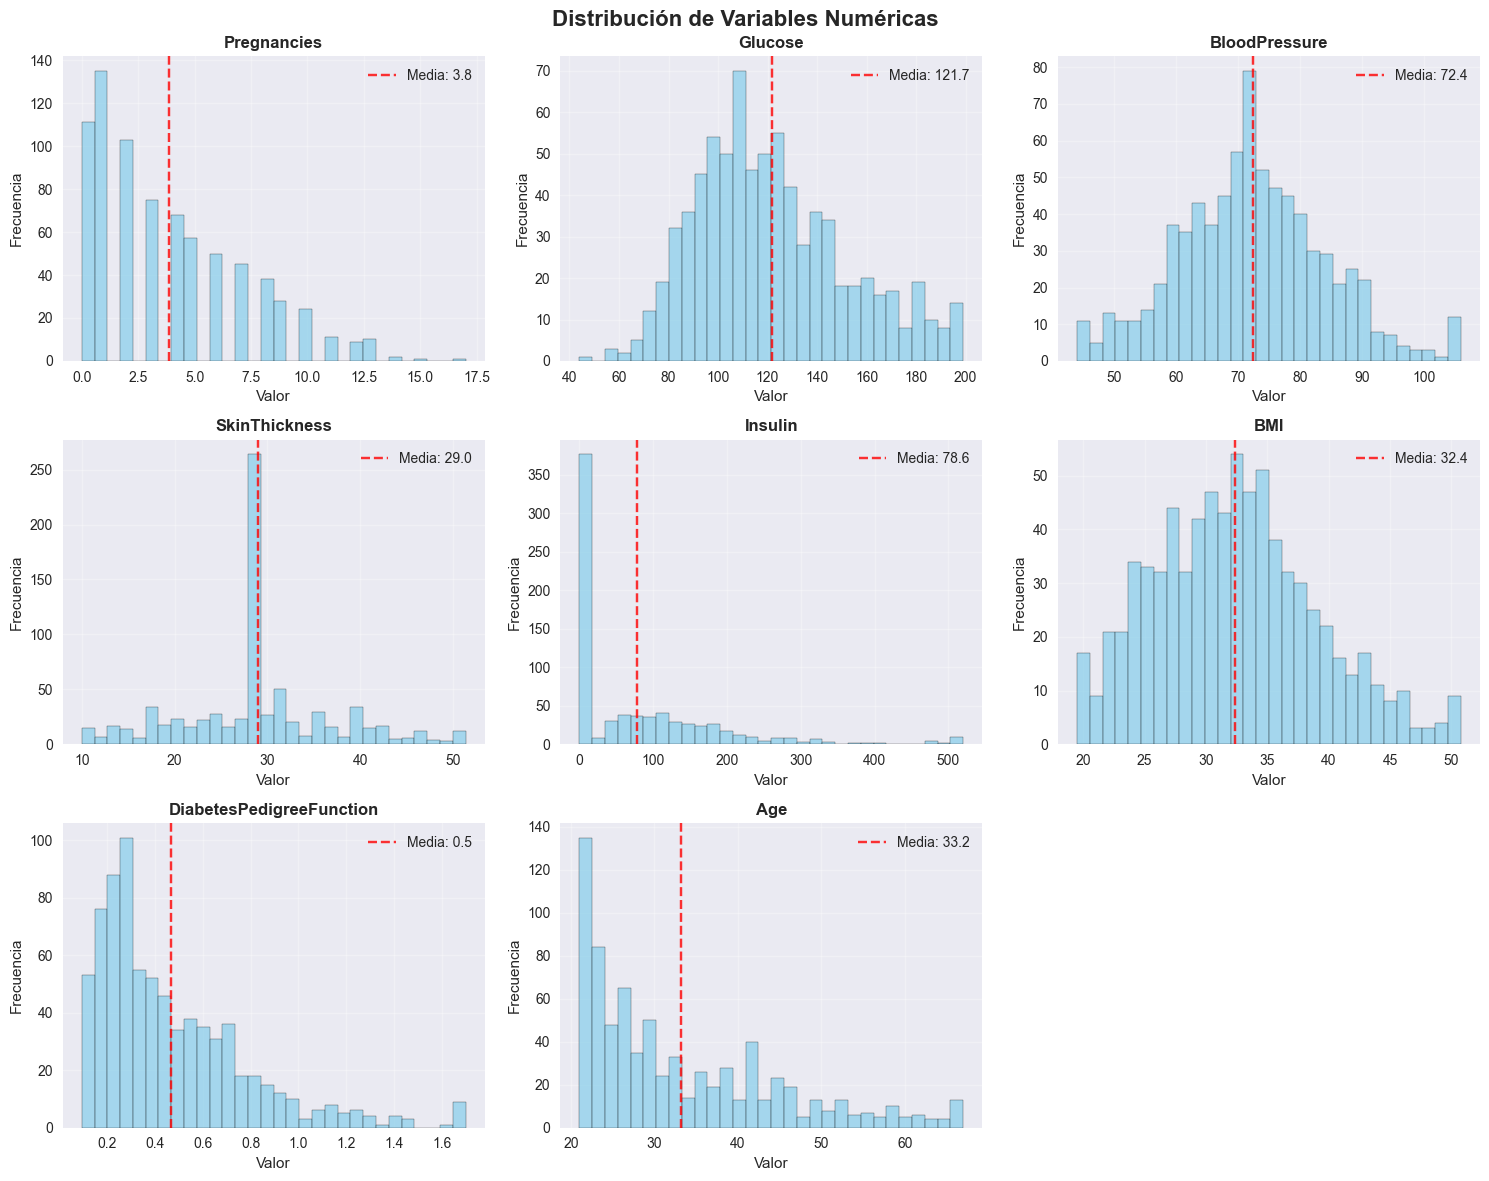


🔍 ANÁLISIS DE DISTRIBUCIONES:
   • Pregnancies: sesgada hacia la derecha (asimetría: 0.902)
   • Glucose: sesgada hacia la derecha (asimetría: 0.536)
   • BloodPressure: aproximadamente simétrica (asimetría: 0.189)
   • SkinThickness: aproximadamente simétrica (asimetría: 0.151)
   • Insulin: sesgada hacia la derecha (asimetría: 1.849)
   • BMI: aproximadamente simétrica (asimetría: 0.376)
   • DiabetesPedigreeFunction: sesgada hacia la derecha (asimetría: 1.492)
   • Age: sesgada hacia la derecha (asimetría: 1.074)


In [10]:
# Histogramas de todas las variables numéricas
print("📊 HISTOGRAMAS DE DISTRIBUCIONES UNIVARIADAS")
print("=" * 50)

# Variables numéricas (excluir Outcome para separar el análisis)
variables_numericas = [col for col in df_final.columns if col != 'Outcome']

# Crear subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle('Distribución de Variables Numéricas', fontsize=16, fontweight='bold')

# Aplanar axes para iterar fácilmente
axes = axes.flatten()

# Crear histograma para cada variable
for i, variable in enumerate(variables_numericas):
    axes[i].hist(df_final[variable], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{variable}', fontweight='bold')
    axes[i].set_xlabel('Valor')
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True, alpha=0.3)
    
    # Agregar línea de media
    media = df_final[variable].mean()
    axes[i].axvline(media, color='red', linestyle='--', alpha=0.8, label=f'Media: {media:.1f}')
    axes[i].legend()

# Ocultar el subplot extra
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Análisis de distribuciones
print("\n🔍 ANÁLISIS DE DISTRIBUCIONES:")
for variable in variables_numericas:
    skewness = df_final[variable].skew()
    kurtosis = df_final[variable].kurtosis()
    
    # Interpretación de asimetría
    if abs(skewness) < 0.5:
        asimetria_desc = "aproximadamente simétrica"
    elif skewness > 0.5:
        asimetria_desc = "sesgada hacia la derecha"
    else:
        asimetria_desc = "sesgada hacia la izquierda"
    
    print(f"   • {variable}: {asimetria_desc} (asimetría: {skewness:.3f})")

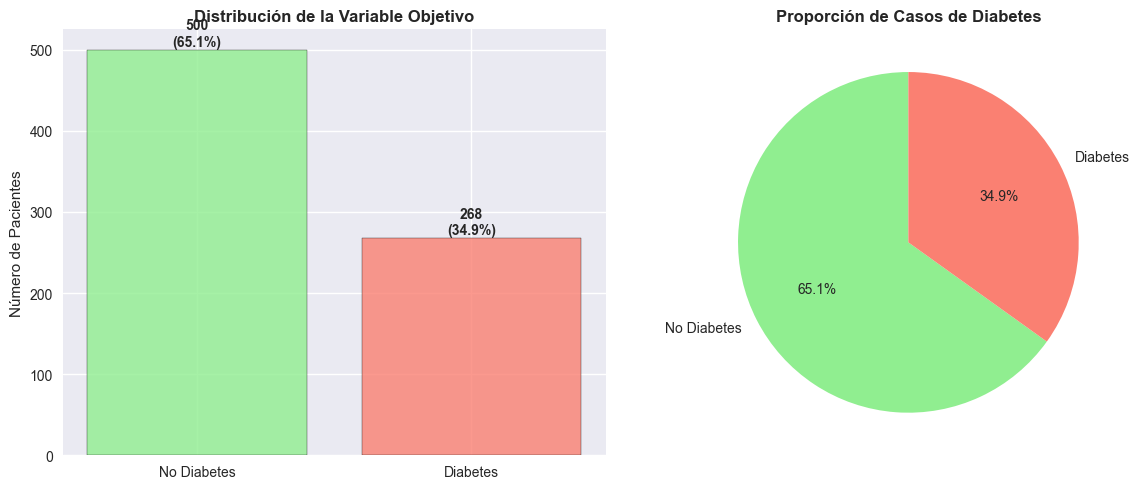


📦 BOXPLOTS PARA DETECCIÓN DE VALORES ATÍPICOS:


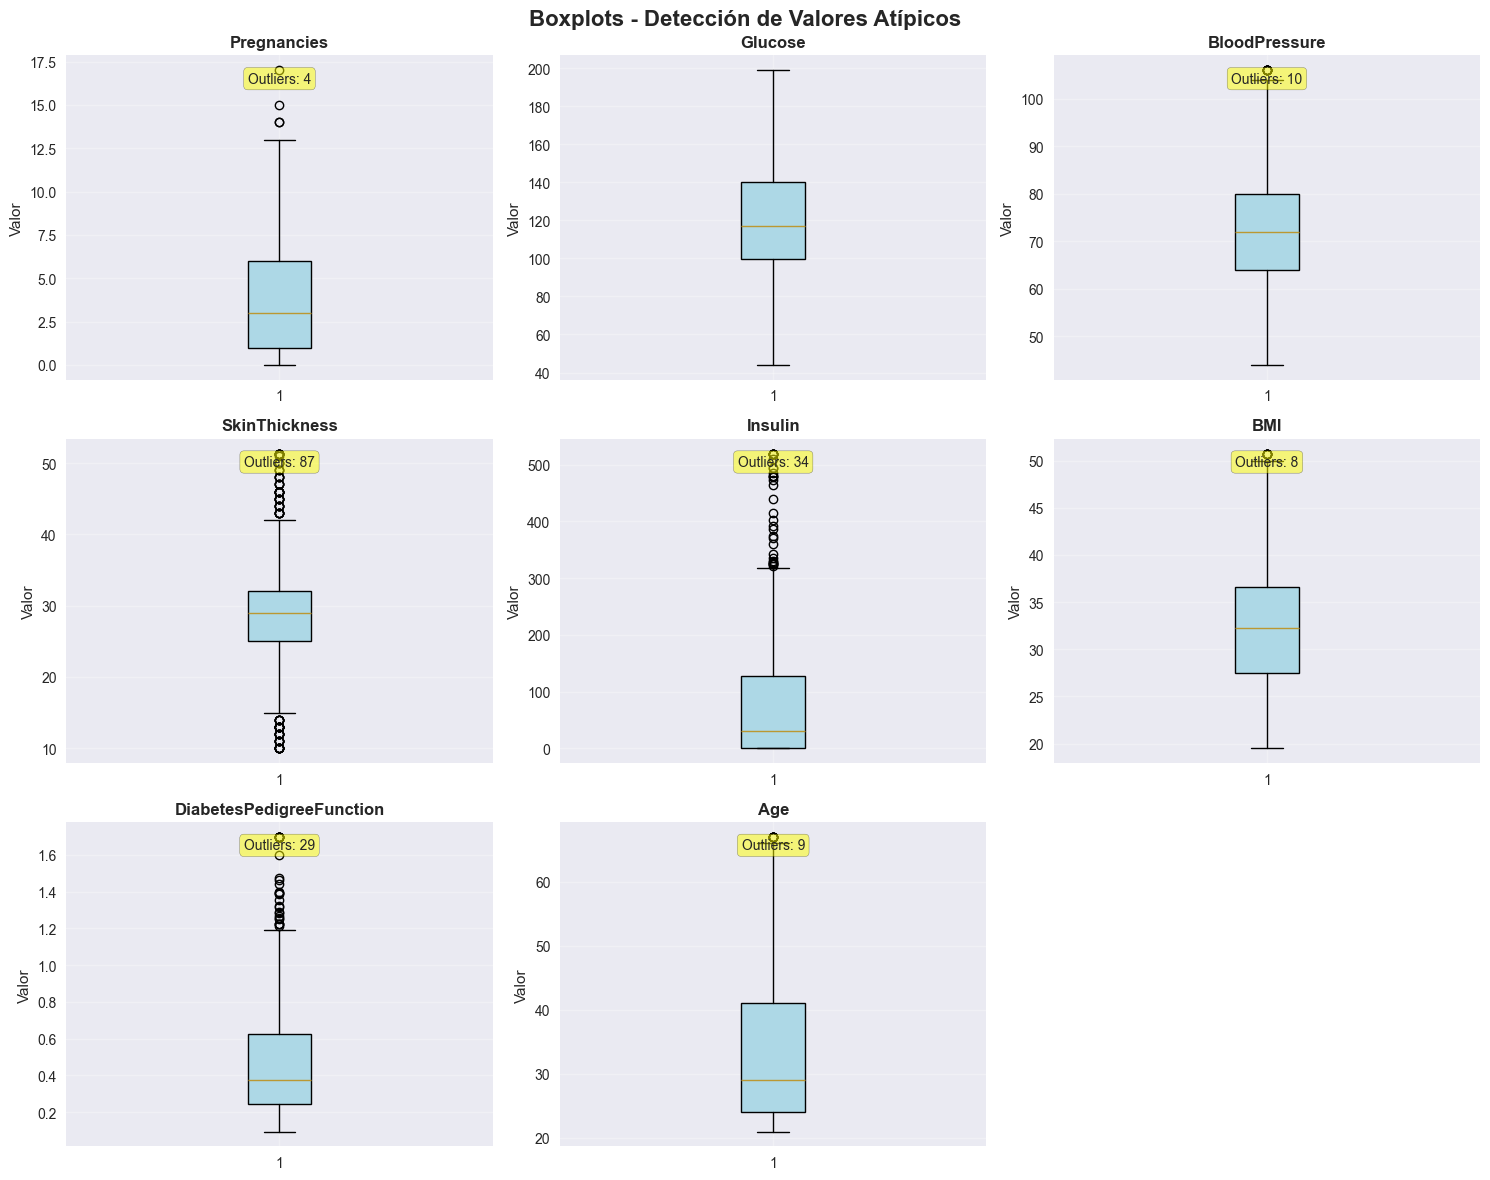

In [11]:
# Visualización de la variable objetivo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras para Outcome
counts = df_final['Outcome'].value_counts()
labels = ['No Diabetes', 'Diabetes']
colors = ['lightgreen', 'salmon']

ax1.bar(labels, counts.values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Distribución de la Variable Objetivo', fontweight='bold')
ax1.set_ylabel('Número de Pacientes')

# Agregar etiquetas con valores y porcentajes
for i, (count, pct) in enumerate(zip(counts.values, counts.values/sum(counts.values)*100)):
    ax1.text(i, count + 5, f'{count}\n({pct:.1f}%)', ha='center', fontweight='bold')

# Gráfico de pie
ax2.pie(counts.values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Proporción de Casos de Diabetes', fontweight='bold')

plt.tight_layout()
plt.show()

# Boxplots para detectar valores atípicos
print("\n📦 BOXPLOTS PARA DETECCIÓN DE VALORES ATÍPICOS:")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle('Boxplots - Detección de Valores Atípicos', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i, variable in enumerate(variables_numericas):
    box_plot = axes[i].boxplot(df_final[variable], patch_artist=True)
    axes[i].set_title(f'{variable}', fontweight='bold')
    axes[i].set_ylabel('Valor')
    axes[i].grid(True, alpha=0.3)
    
    # Colorear las cajas
    box_plot['boxes'][0].set_facecolor('lightblue')
    
    # Calcular y mostrar estadísticas de outliers
    Q1 = df_final[variable].quantile(0.25)
    Q3 = df_final[variable].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_final[(df_final[variable] < Q1 - 1.5*IQR) | (df_final[variable] > Q3 + 1.5*IQR)][variable]
    
    if len(outliers) > 0:
        axes[i].text(0.5, 0.95, f'Outliers: {len(outliers)}', transform=axes[i].transAxes, 
                    ha='center', va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

## 6. Visualizaciones Multivariadas

Exploramos las relaciones entre variables usando diagramas de dispersión, mapas de calor de correlación y comparaciones por grupos.

🔥 MAPA DE CALOR DE CORRELACIONES


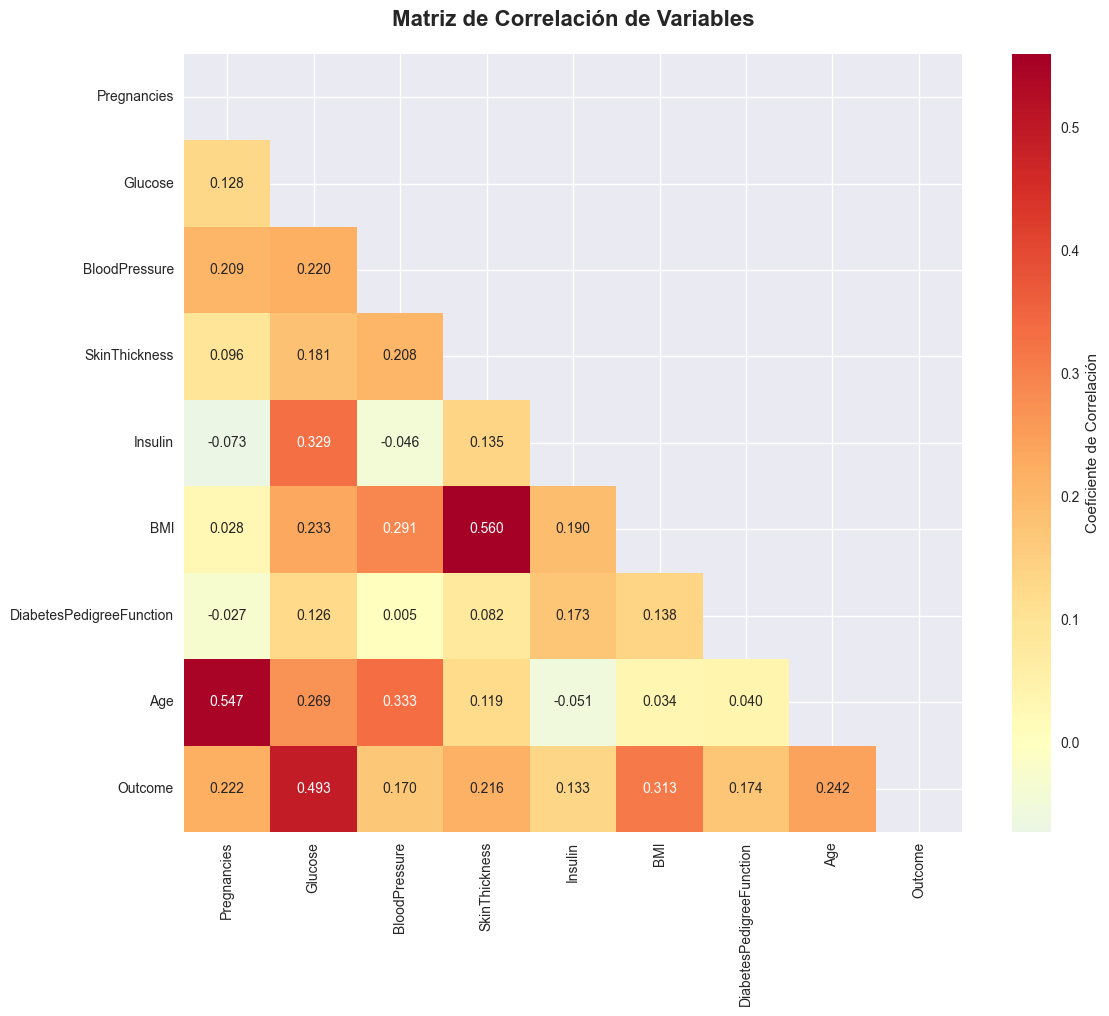


🎯 CORRELACIONES MÁS FUERTES CON LA VARIABLE OBJETIVO:
   • Glucose: 0.493 (correlación positiva fuerte)
   • BMI: 0.313 (correlación positiva fuerte)
   • Age: 0.242 (correlación positiva moderada)
   • Pregnancies: 0.222 (correlación positiva moderada)
   • SkinThickness: 0.216 (correlación positiva moderada)
   • DiabetesPedigreeFunction: 0.174 (correlación positiva moderada)
   • BloodPressure: 0.170 (correlación positiva moderada)
   • Insulin: 0.133 (correlación positiva moderada)

🔗 CORRELACIONES MÁS ALTAS ENTRE VARIABLES PREDICTORAS:
   • SkinThickness ↔ BMI: 0.560
   • Pregnancies ↔ Age: 0.547
   • BloodPressure ↔ Age: 0.333
   • Glucose ↔ Insulin: 0.329


In [12]:
# 1. Mapa de calor de correlaciones
print("🔥 MAPA DE CALOR DE CORRELACIONES")
print("=" * 50)

# Calcular matriz de correlación
correlacion = df_final.corr()

# Crear mapa de calor
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlacion, dtype=bool))  # Máscara para mostrar solo la mitad inferior

sns.heatmap(correlacion, 
            mask=mask,
            annot=True, 
            cmap='RdYlBu_r', 
            center=0,
            square=True,
            fmt='.3f',
            cbar_kws={'label': 'Coeficiente de Correlación'})

plt.title('Matriz de Correlación de Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Análisis de correlaciones más importantes con Outcome
print("\n🎯 CORRELACIONES MÁS FUERTES CON LA VARIABLE OBJETIVO:")
corr_outcome = correlacion['Outcome'].drop('Outcome').sort_values(key=abs, ascending=False)

for variable, corr_value in corr_outcome.items():
    if abs(corr_value) > 0.1:  # Solo mostrar correlaciones moderadas o fuertes
        direccion = "positiva" if corr_value > 0 else "negativa"
        fuerza = "fuerte" if abs(corr_value) > 0.3 else "moderada" if abs(corr_value) > 0.1 else "débil"
        print(f"   • {variable}: {corr_value:.3f} (correlación {direccion} {fuerza})")

# Identificar las correlaciones más altas entre variables predictoras
print("\n🔗 CORRELACIONES MÁS ALTAS ENTRE VARIABLES PREDICTORAS:")
# Obtener correlaciones sin la variable objetivo
corr_predictoras = correlacion.drop('Outcome').drop('Outcome', axis=1)

# Encontrar pares con correlación alta (sin incluir diagonal)
altas_correlaciones = []
for i in range(len(corr_predictoras.columns)):
    for j in range(i+1, len(corr_predictoras.columns)):
        var1 = corr_predictoras.columns[i]
        var2 = corr_predictoras.columns[j]
        corr_val = corr_predictoras.loc[var1, var2]
        if abs(corr_val) > 0.3:  # Umbral para correlación alta
            altas_correlaciones.append((var1, var2, corr_val))

# Ordenar por valor absoluto de correlación
altas_correlaciones.sort(key=lambda x: abs(x[2]), reverse=True)

for var1, var2, corr_val in altas_correlaciones:
    print(f"   • {var1} ↔ {var2}: {corr_val:.3f}")


📊 DIAGRAMAS DE DISPERSIÓN - VARIABLES MÁS CORRELACIONADAS CON DIABETES


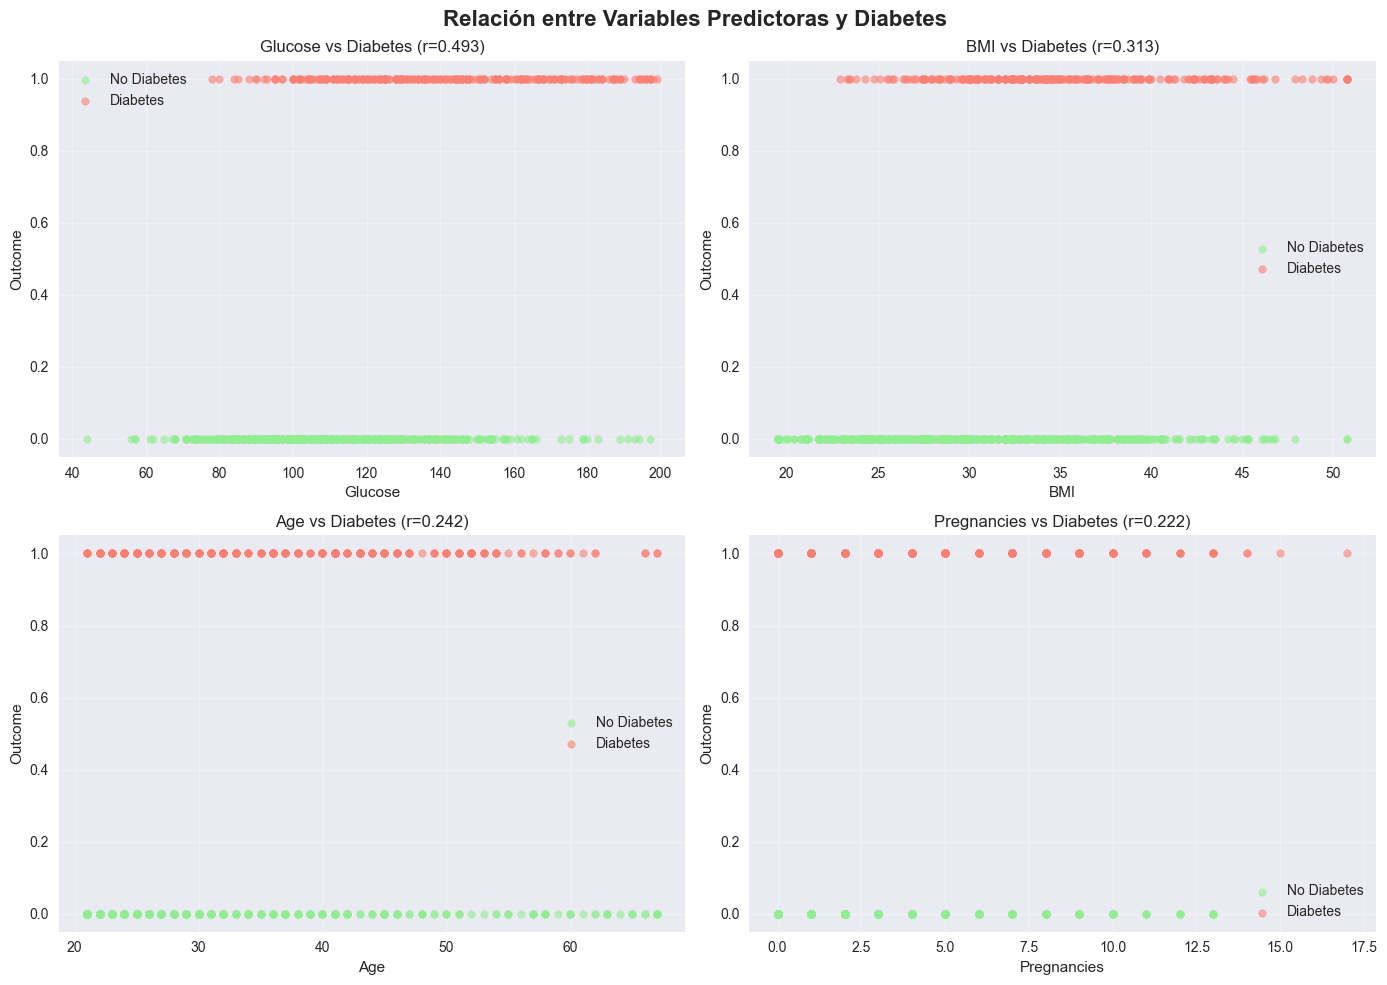


📦 COMPARACIÓN DE DISTRIBUCIONES POR DIAGNÓSTICO


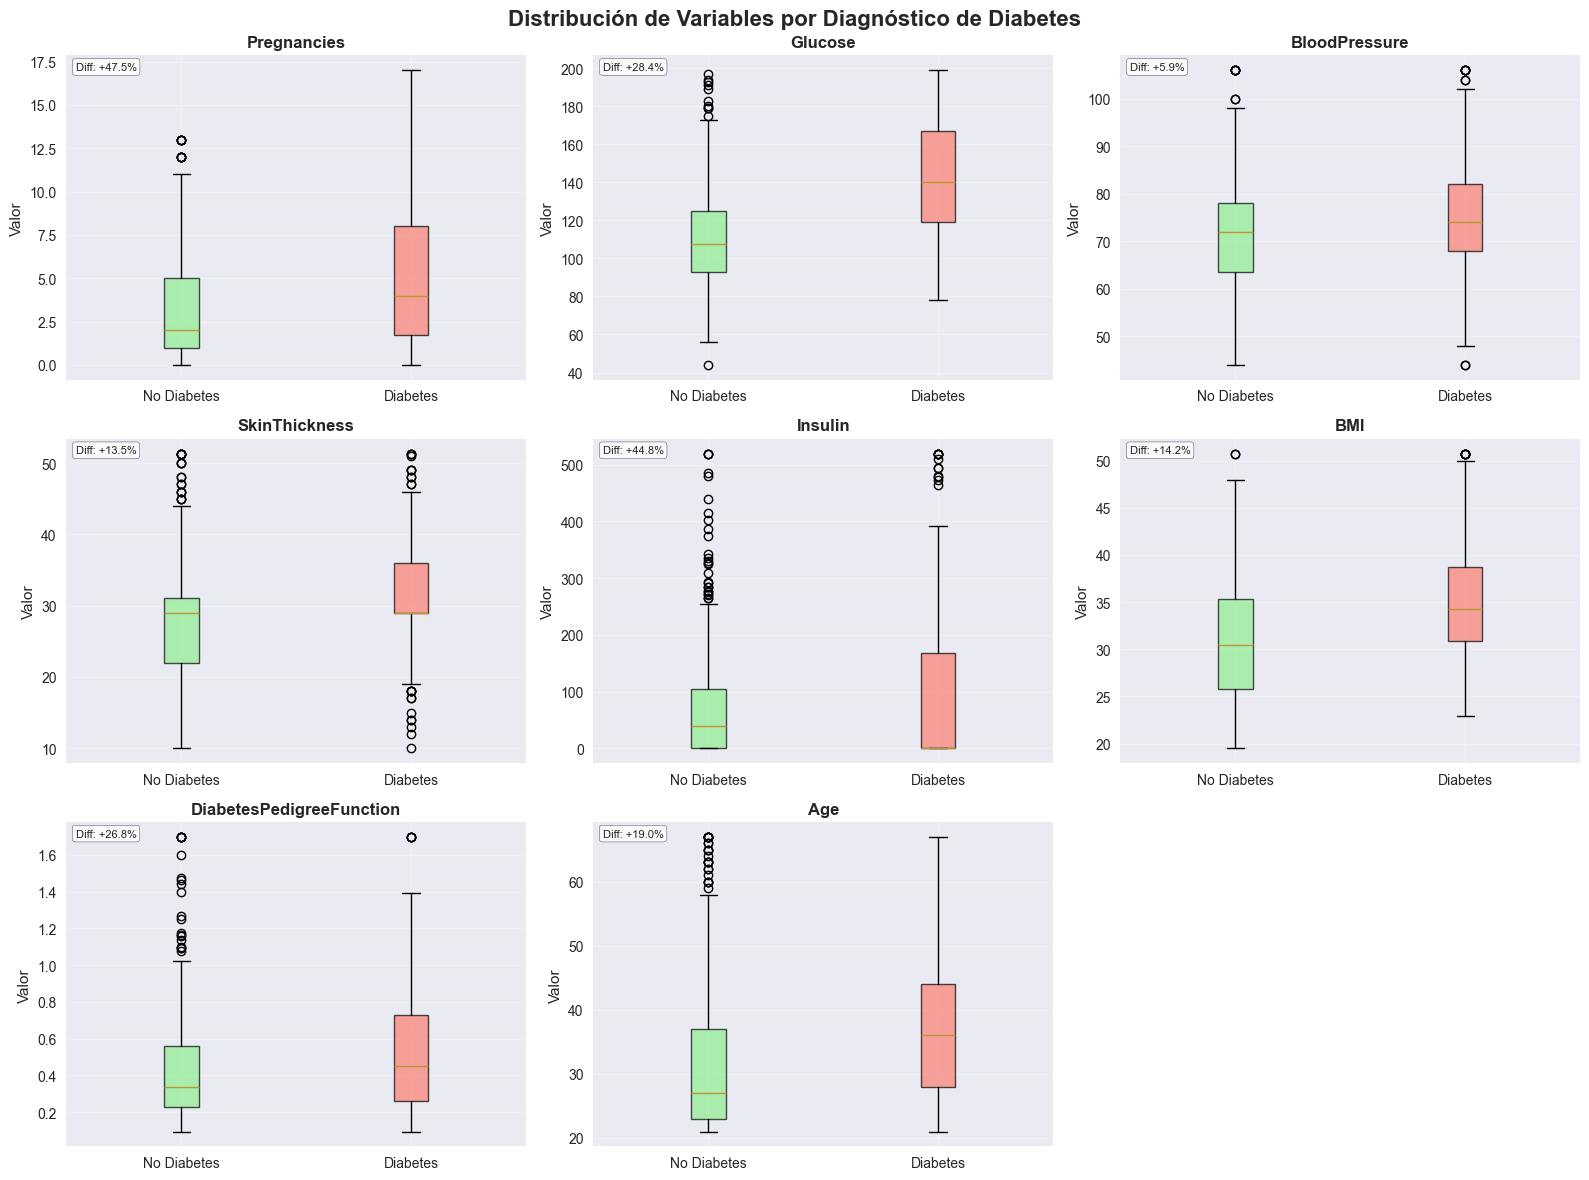

In [13]:
# 2. Diagramas de dispersión de las variables más correlacionadas
print("\n📊 DIAGRAMAS DE DISPERSIÓN - VARIABLES MÁS CORRELACIONADAS CON DIABETES")

# Seleccionar las top 4 variables más correlacionadas con Outcome
top_variables = corr_outcome.head(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Relación entre Variables Predictoras y Diabetes', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i, variable in enumerate(top_variables):
    # Separar por outcome para colorear
    no_diabetes = df_final[df_final['Outcome'] == 0][variable]
    diabetes = df_final[df_final['Outcome'] == 1][variable]
    
    axes[i].scatter(no_diabetes, [0]*len(no_diabetes), alpha=0.6, c='lightgreen', 
                   label='No Diabetes', s=30)
    axes[i].scatter(diabetes, [1]*len(diabetes), alpha=0.6, c='salmon', 
                   label='Diabetes', s=30)
    
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel('Outcome')
    axes[i].set_title(f'{variable} vs Diabetes (r={corr_outcome[variable]:.3f})')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Boxplots comparativos por diagnóstico
print("\n📦 COMPARACIÓN DE DISTRIBUCIONES POR DIAGNÓSTICO")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
fig.suptitle('Distribución de Variables por Diagnóstico de Diabetes', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i, variable in enumerate(variables_numericas):
    # Crear boxplot comparativo
    data_grouped = [df_final[df_final['Outcome'] == 0][variable], 
                   df_final[df_final['Outcome'] == 1][variable]]
    
    box_plot = axes[i].boxplot(data_grouped, 
                              labels=['No Diabetes', 'Diabetes'],
                              patch_artist=True)
    
    # Colorear las cajas
    colors = ['lightgreen', 'salmon']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[i].set_title(f'{variable}', fontweight='bold')
    axes[i].set_ylabel('Valor')
    axes[i].grid(True, alpha=0.3)
    
    # Agregar estadísticas
    no_diab_mean = df_final[df_final['Outcome'] == 0][variable].mean()
    diab_mean = df_final[df_final['Outcome'] == 1][variable].mean()
    diff = ((diab_mean - no_diab_mean) / no_diab_mean) * 100
    
    axes[i].text(0.02, 0.98, f'Diff: {diff:+.1f}%', transform=axes[i].transAxes, 
                va='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

## 7. Preparación de Datos para Modelado con Pipelines

Utilizamos Pipelines y ColumnTransformers para crear un flujo de preprocesamiento robusto y reproducible siguiendo las mejores prácticas de Machine Learning.

In [14]:
print("🔧 PREPARACIÓN DE DATOS CON PIPELINES Y COLUMN TRANSFORMERS")
print("=" * 60)

# 1. Separar características (X) y variable objetivo (y)
X = df_final.drop('Outcome', axis=1)
y = df_final['Outcome']

print("1️⃣ SEPARACIÓN DE VARIABLES:")
print(f"   • Características (X): {X.shape}")
print(f"   • Variable objetivo (y): {y.shape}")
print(f"   • Variables predictoras: {list(X.columns)}")

# 2. División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     # 20% para prueba
    random_state=42,   # Para reproducibilidad
    stratify=y         # Mantener la proporción de clases
)

print("\n2️⃣ DIVISIÓN DE DATOS:")
print(f"   • Conjunto de entrenamiento: {X_train.shape[0]} muestras ({(X_train.shape[0]/len(df_final))*100:.1f}%)")
print(f"   • Conjunto de prueba: {X_test.shape[0]} muestras ({(X_test.shape[0]/len(df_final))*100:.1f}%)")

# Verificar distribución de clases en cada conjunto
print("\n   📊 Distribución de clases:")
print("   Entrenamiento:")
train_dist = y_train.value_counts(normalize=True) * 100
print(f"      - No Diabetes: {train_dist[0]:.1f}%")
print(f"      - Diabetes: {train_dist[1]:.1f}%")

print("   Prueba:")
test_dist = y_test.value_counts(normalize=True) * 100
print(f"      - No Diabetes: {test_dist[0]:.1f}%")
print(f"      - Diabetes: {test_dist[1]:.1f}%")

# 3. Definir grupos de variables para diferentes transformaciones
print("\n3️⃣ DEFINICIÓN DE GRUPOS DE VARIABLES:")

# Identificar variables que pueden beneficiarse de diferentes escalamientos
variables_normales = ['Pregnancies', 'Age']  # Variables con distribución relativamente normal
variables_con_outliers = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']

print(f"   • Variables normales (StandardScaler): {variables_normales}")
print(f"   • Variables con outliers (RobustScaler): {variables_con_outliers}")

# 4. Crear transformadores personalizados
print("\n4️⃣ CREACIÓN DE COLUMN TRANSFORMERS:")

# Transformador para variables normales
normal_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Transformador para variables con outliers
robust_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# ColumnTransformer que aplica diferentes transformaciones según el tipo de variable
preprocessor = ColumnTransformer(
    transformers=[
        ('normal', normal_transformer, variables_normales),
        ('robust', robust_transformer, variables_con_outliers)
    ],
    remainder='passthrough',  # Mantener variables no transformadas
    n_jobs=-1  # Paralelización
)

print("   ✅ ColumnTransformer creado con múltiples estrategias de escalamiento")

# 5. Crear pipelines completos para cada modelo
print("\n5️⃣ CREACIÓN DE PIPELINES COMPLETOS:")

# Pipeline para Random Forest (menos sensible al escalamiento)
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Pipeline para XGBoost (más sensible al escalamiento)
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'))
])

print("   ✅ Pipeline Random Forest creado")
print("   ✅ Pipeline XGBoost creado")

# 6. Configurar validación cruzada estratificada
print("\n6️⃣ CONFIGURACIÓN DE VALIDACIÓN CRUZADA:")

# Configurar estratificación para validación cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("   ✅ Validación cruzada estratificada configurada (5 folds)")

print("\n✅ RESUMEN DE PREPARACIÓN CON PIPELINES:")
print("   • ✅ Datos divididos estratificadamente")
print("   • ✅ ColumnTransformer configurado para diferentes tipos de variables")
print("   • ✅ Pipelines completos creados para ambos modelos")
print("   • ✅ Validación cruzada estratificada lista")
print("   • ✅ Preprocesamiento automático garantizado")
print("   • ✅ Sin data leakage entre entrenamiento y prueba")

🔧 PREPARACIÓN DE DATOS CON PIPELINES Y COLUMN TRANSFORMERS
1️⃣ SEPARACIÓN DE VARIABLES:
   • Características (X): (768, 8)
   • Variable objetivo (y): (768,)
   • Variables predictoras: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

2️⃣ DIVISIÓN DE DATOS:
   • Conjunto de entrenamiento: 614 muestras (79.9%)
   • Conjunto de prueba: 154 muestras (20.1%)

   📊 Distribución de clases:
   Entrenamiento:
      - No Diabetes: 65.1%
      - Diabetes: 34.9%
   Prueba:
      - No Diabetes: 64.9%
      - Diabetes: 35.1%

3️⃣ DEFINICIÓN DE GRUPOS DE VARIABLES:
   • Variables normales (StandardScaler): ['Pregnancies', 'Age']
   • Variables con outliers (RobustScaler): ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']

4️⃣ CREACIÓN DE COLUMN TRANSFORMERS:
   ✅ ColumnTransformer creado con múltiples estrategias de escalamiento

5️⃣ CREACIÓN DE PIPELINES COMPLETOS:
   ✅ Pipeline Random Forest

## 8. Implementación y Optimización de Random Forest

Implementamos Random Forest con optimización de hiperparámetros usando GridSearchCV y evaluamos su rendimiento.

🌳 RANDOM FOREST CON OPTIMIZACIÓN DE HIPERPARÁMETROS
1️⃣ DEFINICIÓN DEL ESPACIO DE HIPERPARÁMETROS:
   • Espacio de búsqueda definido con 6 hiperparámetros
   • Combinaciones posibles: 972

   💡 Usando RandomizedSearchCV para eficiencia computacional

2️⃣ CONFIGURACIÓN DE RANDOMIZED SEARCH:
   ✅ RandomizedSearchCV configurado
   • Iteraciones: 50
   • Métrica de optimización: F1-Score
   • Validación cruzada: 5-fold estratificada

3️⃣ ENTRENAMIENTO Y OPTIMIZACIÓN:
   🔄 Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
   ✅ Optimización completada

   🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:
      • n_estimators: 50
      • min_samples_split: 5
      • min_samples_leaf: 2
      • max_features: log2
      • max_depth: 5
      • class_weight: balanced

   📊 Mejor F1-Score en validación cruzada: 0.6917

4️⃣ EVALUACIÓN EN CONJUNTO DE PRUEBA:
   📈 MÉTRICAS DE RENDIMIENTO:
      • Accuracy: 0.7468 (74.68%)
      • Precision: 0.6087
      • Rec

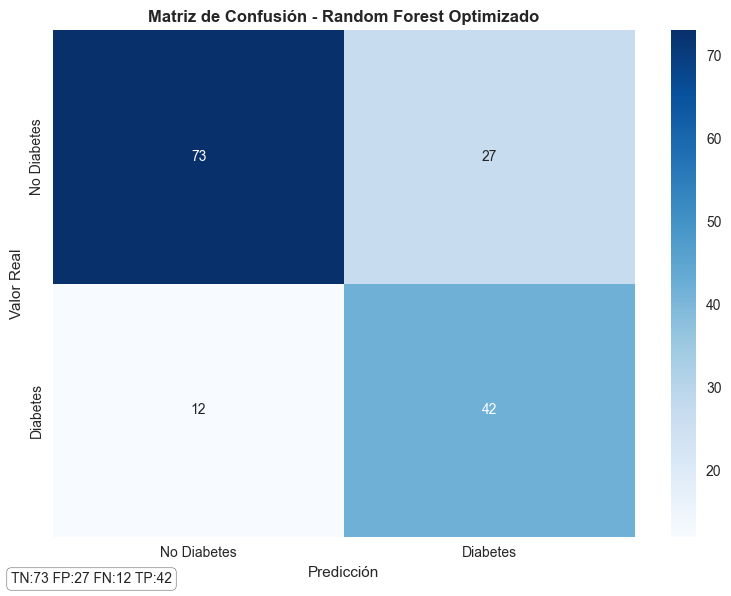

   📊 Interpretación de la matriz:
      • Verdaderos Negativos (TN): 73
      • Falsos Positivos (FP): 27
      • Falsos Negativos (FN): 12
      • Verdaderos Positivos (TP): 42

6️⃣ IMPORTANCIA DE CARACTERÍSTICAS:
   🔝 Ranking de importancia (Top 5):
      3. Glucose: 0.3970
      7. BMI: 0.2047
      2. Age: 0.1317
      8. DiabetesPedigreeFunction: 0.0732
      1. Pregnancies: 0.0659


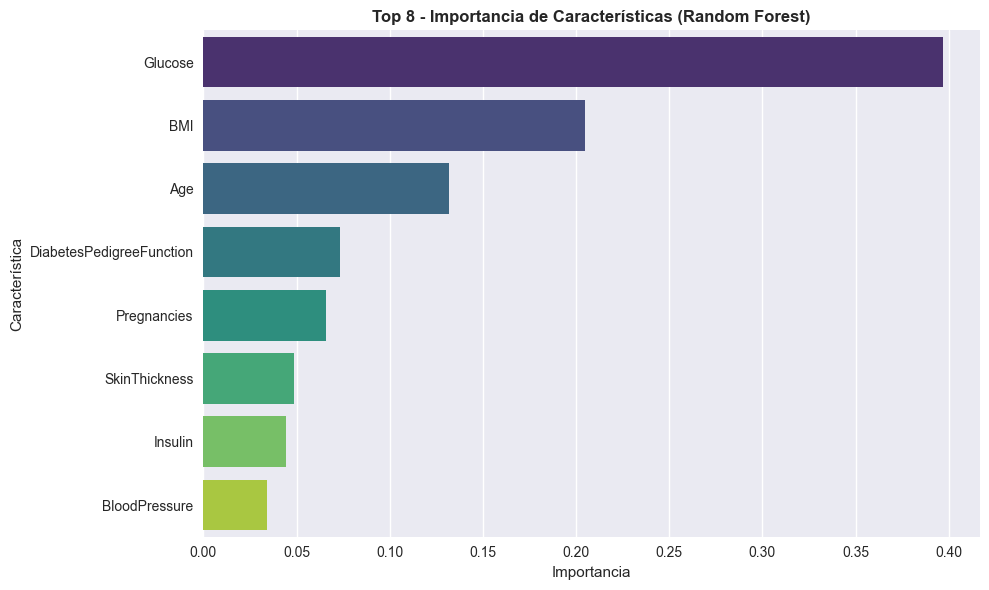


7️⃣ ANÁLISIS DE VALIDACIÓN CRUZADA:
   📊 Estadísticas de validación cruzada:
      • Mejor score: 0.6917 (±0.0183)
      • Score promedio: 0.6552
      • Desviación estándar: 0.0218

✅ RANDOM FOREST OPTIMIZADO COMPLETADO:
   • ✅ Hiperparámetros optimizados con RandomizedSearchCV
   • ✅ Pipeline completo con preprocesamiento automático
   • ✅ Validación cruzada estratificada aplicada
   • ✅ Modelo listo para comparación


In [15]:
print("🌳 RANDOM FOREST CON OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("=" * 60)

# 1. Definir espacio de búsqueda de hiperparámetros
print("1️⃣ DEFINICIÓN DEL ESPACIO DE HIPERPARÁMETROS:")

# Parámetros para Random Forest
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__class_weight': ['balanced', 'balanced_subsample', None]
}

print(f"   • Espacio de búsqueda definido con {len(rf_param_grid)} hiperparámetros")
print(f"   • Combinaciones posibles: {np.prod([len(v) for v in rf_param_grid.values()]):,}")

# Para acelerar el proceso, usaremos RandomizedSearchCV
print("\n   💡 Usando RandomizedSearchCV para eficiencia computacional")

# 2. Configurar búsqueda aleatoria de hiperparámetros
print("\n2️⃣ CONFIGURACIÓN DE RANDOMIZED SEARCH:")

rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_grid,
    n_iter=50,  # Número de combinaciones a probar
    cv=cv_strategy,  # Validación cruzada estratificada
    scoring='f1',  # Métrica de optimización (importante en medicina)
    n_jobs=-1,  # Paralelización
    random_state=42,
    verbose=1  # Mostrar progreso
)

print("   ✅ RandomizedSearchCV configurado")
print(f"   • Iteraciones: 50")
print(f"   • Métrica de optimización: F1-Score")
print(f"   • Validación cruzada: 5-fold estratificada")

# 3. Entrenar y optimizar Random Forest
print("\n3️⃣ ENTRENAMIENTO Y OPTIMIZACIÓN:")
print("   🔄 Iniciando búsqueda de hiperparámetros...")

# Entrenar con búsqueda de hiperparámetros
rf_random_search.fit(X_train, y_train)

print("   ✅ Optimización completada")

# Mejor modelo encontrado
best_rf_model = rf_random_search.best_estimator_
best_rf_params = rf_random_search.best_params_
best_rf_score = rf_random_search.best_score_

print(f"\n   🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:")
for param, value in best_rf_params.items():
    print(f"      • {param.replace('classifier__', '')}: {value}")

print(f"\n   📊 Mejor F1-Score en validación cruzada: {best_rf_score:.4f}")

# 4. Evaluación en conjunto de prueba
print("\n4️⃣ EVALUACIÓN EN CONJUNTO DE PRUEBA:")

# Predicciones con el mejor modelo
y_pred_rf = best_rf_model.predict(X_test)
y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Métricas de evaluación
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"   📈 MÉTRICAS DE RENDIMIENTO:")
print(f"      • Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")
print(f"      • Precision: {precision_rf:.4f}")
print(f"      • Recall: {recall_rf:.4f}")
print(f"      • F1-Score: {f1_rf:.4f}")
print(f"      • ROC-AUC: {roc_auc_rf:.4f}")

# 5. Matriz de confusión
print("\n5️⃣ MATRIZ DE CONFUSIÓN:")
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Matriz de Confusión - Random Forest Optimizado', fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')

# Añadir información adicional
tn, fp, fn, tp = cm_rf.ravel()
plt.figtext(0.02, 0.02, f'TN:{tn} FP:{fp} FN:{fn} TP:{tp}', fontsize=10, 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

print(f"   📊 Interpretación de la matriz:")
print(f"      • Verdaderos Negativos (TN): {tn}")
print(f"      • Falsos Positivos (FP): {fp}")
print(f"      • Falsos Negativos (FN): {fn}")
print(f"      • Verdaderos Positivos (TP): {tp}")

# 6. Importancia de características
print("\n6️⃣ IMPORTANCIA DE CARACTERÍSTICAS:")

# Obtener el clasificador Random Forest del pipeline
rf_classifier = best_rf_model.named_steps['classifier']
feature_names = best_rf_model.named_steps['preprocessor'].get_feature_names_out()

# Crear DataFrame con importancias
feature_importance_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("   🔝 Ranking de importancia (Top 5):")
for idx, row in feature_importance_rf.head().iterrows():
    feature_clean = row['Feature'].split('__')[-1] if '__' in row['Feature'] else row['Feature']
    print(f"      {idx+1}. {feature_clean}: {row['Importance']:.4f}")

# Visualización de importancia
plt.figure(figsize=(10, 6))
top_features = feature_importance_rf.head(8)  # Top 8 para mejor visualización
top_features['Feature_Clean'] = top_features['Feature'].apply(
    lambda x: x.split('__')[-1] if '__' in x else x
)

sns.barplot(data=top_features, x='Importance', y='Feature_Clean', palette='viridis')
plt.title('Top 8 - Importancia de Características (Random Forest)', fontweight='bold')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# 7. Análisis de validación cruzada
print("\n7️⃣ ANÁLISIS DE VALIDACIÓN CRUZADA:")

# Resultados detallados de CV
cv_results = rf_random_search.cv_results_
mean_scores = cv_results['mean_test_score']
std_scores = cv_results['std_test_score']

print(f"   📊 Estadísticas de validación cruzada:")
print(f"      • Mejor score: {np.max(mean_scores):.4f} (±{std_scores[np.argmax(mean_scores)]:.4f})")
print(f"      • Score promedio: {np.mean(mean_scores):.4f}")
print(f"      • Desviación estándar: {np.std(mean_scores):.4f}")

print(f"\n✅ RANDOM FOREST OPTIMIZADO COMPLETADO:")
print(f"   • ✅ Hiperparámetros optimizados con RandomizedSearchCV")
print(f"   • ✅ Pipeline completo con preprocesamiento automático")
print(f"   • ✅ Validación cruzada estratificada aplicada")
print(f"   • ✅ Modelo listo para comparación")

## 9. Implementación y Optimización de XGBoost

Implementamos XGBoost con optimización de hiperparámetros usando GridSearchCV y evaluamos su rendimiento.

🚀 XGBOOST CON OPTIMIZACIÓN DE HIPERPARÁMETROS
1️⃣ DEFINICIÓN DEL ESPACIO DE HIPERPARÁMETROS:
   • Espacio de búsqueda definido con 8 hiperparámetros
   • Combinaciones posibles: 6,561

   💡 Usando RandomizedSearchCV para eficiencia computacional

2️⃣ CONFIGURACIÓN DE RANDOMIZED SEARCH:
   ✅ RandomizedSearchCV configurado
   • Iteraciones: 50
   • Métrica de optimización: F1-Score
   • Validación cruzada: 5-fold estratificada

3️⃣ ENTRENAMIENTO Y OPTIMIZACIÓN:
   🔄 Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
   ✅ Optimización completada

   🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:
      • subsample: 1.0
      • scale_pos_weight: 3
      • reg_lambda: 1
      • reg_alpha: 0
      • n_estimators: 100
      • max_depth: 3
      • learning_rate: 0.1
      • colsample_bytree: 0.9

   📊 Mejor F1-Score en validación cruzada: 0.6847

4️⃣ EVALUACIÓN EN CONJUNTO DE PRUEBA:
   📈 MÉTRICAS DE RENDIMIENTO:
      • Accuracy: 0.7468 (74.68%)
    

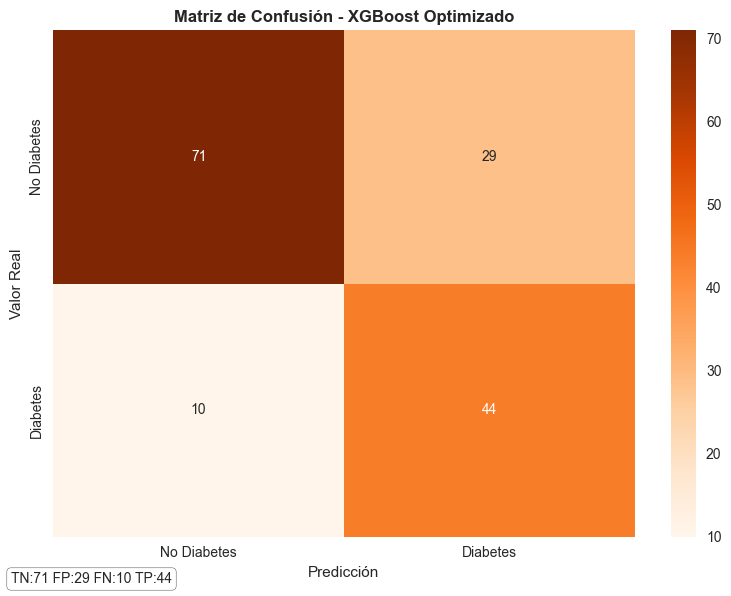

   📊 Interpretación de la matriz:
      • Verdaderos Negativos (TN): 71
      • Falsos Positivos (FP): 29
      • Falsos Negativos (FN): 10
      • Verdaderos Positivos (TP): 44

6️⃣ IMPORTANCIA DE CARACTERÍSTICAS:
   🔝 Ranking de importancia (Top 5):
      3. Glucose: 0.3166
      7. BMI: 0.1601
      2. Age: 0.1337
      1. Pregnancies: 0.0854
      8. DiabetesPedigreeFunction: 0.0838


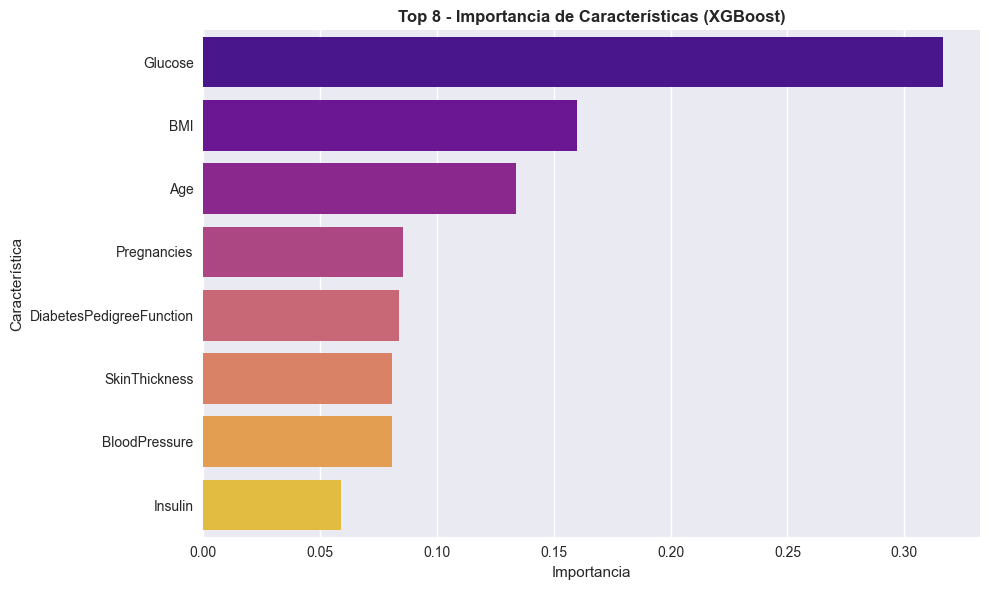


7️⃣ ANÁLISIS DE VALIDACIÓN CRUZADA:
   📊 Estadísticas de validación cruzada:
      • Mejor score: 0.6847 (±0.0260)
      • Score promedio: 0.6358
      • Desviación estándar: 0.0526

✅ XGBOOST OPTIMIZADO COMPLETADO:
   • ✅ Hiperparámetros optimizados con RandomizedSearchCV
   • ✅ Pipeline completo con preprocesamiento automático
   • ✅ Validación cruzada estratificada aplicada
   • ✅ Modelo listo para comparación


In [16]:
print("🚀 XGBOOST CON OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("=" * 60)

# 1. Definir espacio de búsqueda de hiperparámetros para XGBoost
print("1️⃣ DEFINICIÓN DEL ESPACIO DE HIPERPARÁMETROS:")

# Parámetros para XGBoost
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__reg_alpha': [0, 0.1, 0.5],
    'classifier__reg_lambda': [1, 1.5, 2],
    'classifier__scale_pos_weight': [1, 2, 3]
}

print(f"   • Espacio de búsqueda definido con {len(xgb_param_grid)} hiperparámetros")
print(f"   • Combinaciones posibles: {np.prod([len(v) for v in xgb_param_grid.values()]):,}")

print("\n   💡 Usando RandomizedSearchCV para eficiencia computacional")

# 2. Configurar búsqueda aleatoria de hiperparámetros
print("\n2️⃣ CONFIGURACIÓN DE RANDOMIZED SEARCH:")

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_grid,
    n_iter=50,  # Número de combinaciones a probar
    cv=cv_strategy,  # Validación cruzada estratificada
    scoring='f1',  # Métrica de optimización
    n_jobs=-1,  # Paralelización
    random_state=42,
    verbose=1  # Mostrar progreso
)

print("   ✅ RandomizedSearchCV configurado")
print(f"   • Iteraciones: 50")
print(f"   • Métrica de optimización: F1-Score")
print(f"   • Validación cruzada: 5-fold estratificada")

# 3. Entrenar y optimizar XGBoost
print("\n3️⃣ ENTRENAMIENTO Y OPTIMIZACIÓN:")
print("   🔄 Iniciando búsqueda de hiperparámetros...")

# Entrenar con búsqueda de hiperparámetros
xgb_random_search.fit(X_train, y_train)

print("   ✅ Optimización completada")

# Mejor modelo encontrado
best_xgb_model = xgb_random_search.best_estimator_
best_xgb_params = xgb_random_search.best_params_
best_xgb_score = xgb_random_search.best_score_

print(f"\n   🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:")
for param, value in best_xgb_params.items():
    print(f"      • {param.replace('classifier__', '')}: {value}")

print(f"\n   📊 Mejor F1-Score en validación cruzada: {best_xgb_score:.4f}")

# 4. Evaluación en conjunto de prueba
print("\n4️⃣ EVALUACIÓN EN CONJUNTO DE PRUEBA:")

# Predicciones con el mejor modelo
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Métricas de evaluación
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"   📈 MÉTRICAS DE RENDIMIENTO:")
print(f"      • Accuracy: {accuracy_xgb:.4f} ({accuracy_xgb*100:.2f}%)")
print(f"      • Precision: {precision_xgb:.4f}")
print(f"      • Recall: {recall_xgb:.4f}")
print(f"      • F1-Score: {f1_xgb:.4f}")
print(f"      • ROC-AUC: {roc_auc_xgb:.4f}")

# 5. Matriz de confusión
print("\n5️⃣ MATRIZ DE CONFUSIÓN:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Matriz de Confusión - XGBoost Optimizado', fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')

# Añadir información adicional
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()
plt.figtext(0.02, 0.02, f'TN:{tn_xgb} FP:{fp_xgb} FN:{fn_xgb} TP:{tp_xgb}', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

print(f"   📊 Interpretación de la matriz:")
print(f"      • Verdaderos Negativos (TN): {tn_xgb}")
print(f"      • Falsos Positivos (FP): {fp_xgb}")
print(f"      • Falsos Negativos (FN): {fn_xgb}")
print(f"      • Verdaderos Positivos (TP): {tp_xgb}")

# 6. Importancia de características
print("\n6️⃣ IMPORTANCIA DE CARACTERÍSTICAS:")

# Obtener el clasificador XGBoost del pipeline
xgb_classifier = best_xgb_model.named_steps['classifier']
feature_names_xgb = best_xgb_model.named_steps['preprocessor'].get_feature_names_out()

# Crear DataFrame con importancias
feature_importance_xgb = pd.DataFrame({
    'Feature': feature_names_xgb,
    'Importance': xgb_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("   🔝 Ranking de importancia (Top 5):")
for idx, row in feature_importance_xgb.head().iterrows():
    feature_clean = row['Feature'].split('__')[-1] if '__' in row['Feature'] else row['Feature']
    print(f"      {idx+1}. {feature_clean}: {row['Importance']:.4f}")

# Visualización de importancia
plt.figure(figsize=(10, 6))
top_features_xgb = feature_importance_xgb.head(8)  # Top 8 para mejor visualización
top_features_xgb['Feature_Clean'] = top_features_xgb['Feature'].apply(
    lambda x: x.split('__')[-1] if '__' in x else x
)

sns.barplot(data=top_features_xgb, x='Importance', y='Feature_Clean', palette='plasma')
plt.title('Top 8 - Importancia de Características (XGBoost)', fontweight='bold')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# 7. Análisis de validación cruzada
print("\n7️⃣ ANÁLISIS DE VALIDACIÓN CRUZADA:")

# Resultados detallados de CV
cv_results_xgb = xgb_random_search.cv_results_
mean_scores_xgb = cv_results_xgb['mean_test_score']
std_scores_xgb = cv_results_xgb['std_test_score']

print(f"   📊 Estadísticas de validación cruzada:")
print(f"      • Mejor score: {np.max(mean_scores_xgb):.4f} (±{std_scores_xgb[np.argmax(mean_scores_xgb)]:.4f})")
print(f"      • Score promedio: {np.mean(mean_scores_xgb):.4f}")
print(f"      • Desviación estándar: {np.std(mean_scores_xgb):.4f}")

print(f"\n✅ XGBOOST OPTIMIZADO COMPLETADO:")
print(f"   • ✅ Hiperparámetros optimizados con RandomizedSearchCV")
print(f"   • ✅ Pipeline completo con preprocesamiento automático")
print(f"   • ✅ Validación cruzada estratificada aplicada")
print(f"   • ✅ Modelo listo para comparación")

## 10. Evaluación y Comparación de Modelos Optimizados

Comparamos el rendimiento de ambos modelos optimizados (Random Forest vs XGBoost) y determinamos cuál es más adecuado para este dataset.

⚖️ COMPARACIÓN DE MODELOS OPTIMIZADOS
1️⃣ TABLA COMPARATIVA DE MÉTRICAS (MODELOS OPTIMIZADOS):
1️⃣ TABLA COMPARATIVA DE MÉTRICAS (MODELOS OPTIMIZADOS):

     Métrica  Random Forest (Optimizado)  XGBoost (Optimizado)  \
0   Accuracy                      0.7468                0.7468   
1  Precision                      0.6087                0.6027   
2     Recall                      0.7778                0.8148   
3   F1-Score                      0.6829                0.6929   
4    ROC-AUC                      0.8363                0.8244   

   Diferencia (XGB - RF)  
0                 0.0000  
1                -0.0060  
2                 0.0370  
3                 0.0100  
4                -0.0119  

   📊 COMPARACIÓN DE VALIDACIÓN CRUZADA:
      • Random Forest CV F1-Score: 0.6917
      • XGBoost CV F1-Score: 0.6847
      • Diferencia CV: -0.0070

2️⃣ VISUALIZACIÓN COMPARATIVA:


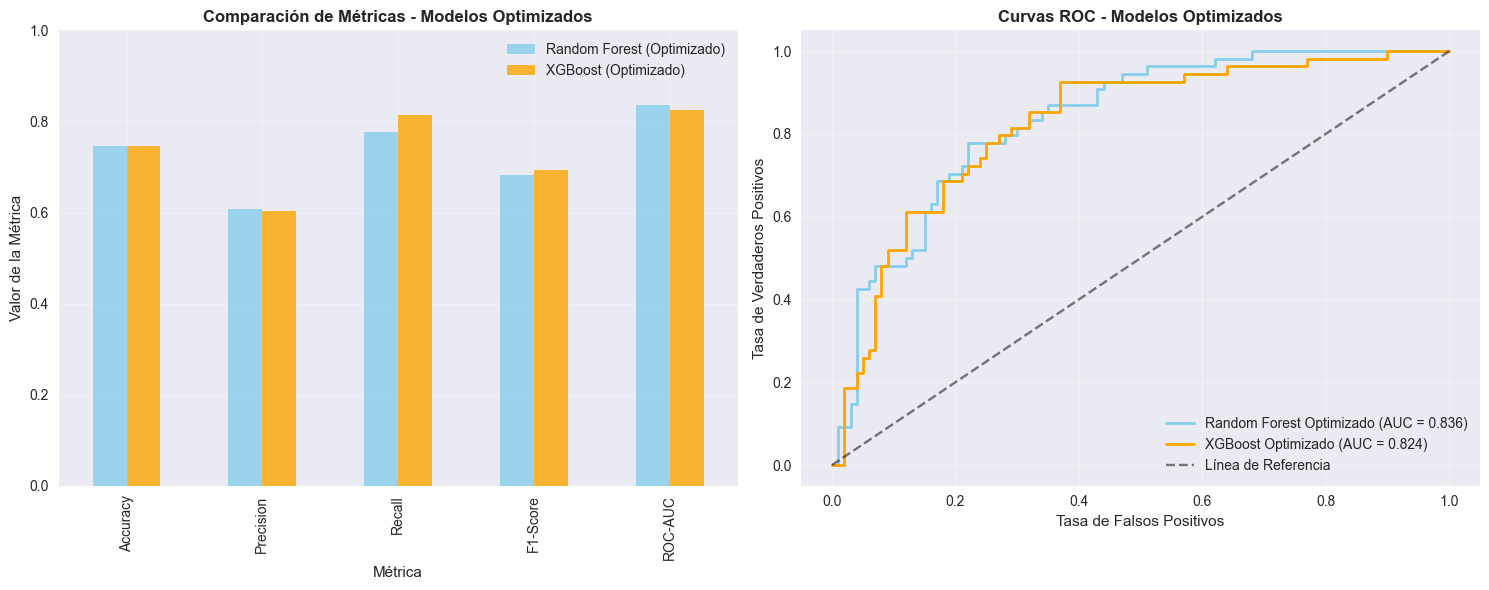


3️⃣ ANÁLISIS DETALLADO:
   🏆 MEJOR MODELO: XGBoost
   📊 Diferencia en F1-Score: 0.0100
   📝 Los modelos tienen rendimiento muy similar

   🔍 ANÁLISIS DE ERRORES (MODELOS OPTIMIZADOS):
   Random Forest Optimizado:
      - Falsos Positivos: 27 (pacientes sanos clasificados como diabéticos)
      - Falsos Negativos: 12 (pacientes diabéticos no detectados)
   XGBoost Optimizado:
      - Falsos Positivos: 29 (pacientes sanos clasificados como diabéticos)
      - Falsos Negativos: 10 (pacientes diabéticos no detectados)
   ✅ XGBoost tiene 2 falsos negativos menos (mejor para detectar diabetes)
   ✅ Random Forest tiene 2 falsos positivos menos (menos diagnósticos incorrectos)

   🎯 RECOMENDACIÓN FINAL:
   🥇 MODELO RECOMENDADO: XGBoost
   📈 Ambos modelos son prácticamente equivalentes (diferencia < 1%)


In [17]:
print("⚖️ COMPARACIÓN DE MODELOS OPTIMIZADOS")
print("=" * 60)

# 1. Tabla comparativa de métricas
print("1️⃣ TABLA COMPARATIVA DE MÉTRICAS (MODELOS OPTIMIZADOS):")

# Crear tabla comparativa
metricas_comparacion = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Random Forest (Optimizado)': [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf],
    'XGBoost (Optimizado)': [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, roc_auc_xgb]
})

# Calcular diferencias
diferencias = []
for i in range(len(metricas_comparacion)):
    diff = metricas_comparacion.iloc[i]['XGBoost (Optimizado)'] - metricas_comparacion.iloc[i]['Random Forest (Optimizado)']
    diferencias.append(diff)

metricas_comparacion['Diferencia (XGB - RF)'] = diferencias

print("1️⃣ TABLA COMPARATIVA DE MÉTRICAS (MODELOS OPTIMIZADOS):")
print()
print(metricas_comparacion.round(4))

print(f"\n   📊 COMPARACIÓN DE VALIDACIÓN CRUZADA:")
print(f"      • Random Forest CV F1-Score: {best_rf_score:.4f}")
print(f"      • XGBoost CV F1-Score: {best_xgb_score:.4f}")
print(f"      • Diferencia CV: {(best_xgb_score - best_rf_score):.4f}")

# 2. Visualización comparativa de métricas
print("\n2️⃣ VISUALIZACIÓN COMPARATIVA:")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras comparativo
metricas_viz = metricas_comparacion.set_index('Métrica')[['Random Forest (Optimizado)', 'XGBoost (Optimizado)']]
metricas_viz.plot(kind='bar', ax=axes[0], color=['skyblue', 'orange'], alpha=0.8)
axes[0].set_title('Comparación de Métricas - Modelos Optimizados', fontweight='bold')
axes[0].set_ylabel('Valor de la Métrica')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

# Curvas ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest Optimizado (AUC = {roc_auc_rf:.3f})', 
             color='skyblue', linewidth=2)
axes[1].plot(fpr_xgb, tpr_xgb, label=f'XGBoost Optimizado (AUC = {roc_auc_xgb:.3f})', 
             color='orange', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Línea de Referencia')
axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].set_title('Curvas ROC - Modelos Optimizados', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Análisis detallado
print("\n3️⃣ ANÁLISIS DETALLADO:")

# Determinar el mejor modelo
diferencia_f1 = f1_xgb - f1_rf
if diferencia_f1 > 0.01:
    mejor_modelo = "XGBoost"
elif diferencia_f1 < -0.01:
    mejor_modelo = "Random Forest"
else:
    mejor_modelo = "XGBoost"  # Por defecto si están muy cerca

print(f"   🏆 MEJOR MODELO: {mejor_modelo}")
print(f"   📊 Diferencia en F1-Score: {diferencia_f1:.4f}")
if abs(diferencia_f1) < 0.02:
    print(f"   📝 Los modelos tienen rendimiento muy similar")

# Definir variables de matriz de confusión para Random Forest
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

# Análisis de errores
print(f"\n   🔍 ANÁLISIS DE ERRORES (MODELOS OPTIMIZADOS):")
print(f"   Random Forest Optimizado:")
print(f"      - Falsos Positivos: {fp_rf} (pacientes sanos clasificados como diabéticos)")
print(f"      - Falsos Negativos: {fn_rf} (pacientes diabéticos no detectados)")
print(f"   XGBoost Optimizado:")
print(f"      - Falsos Positivos: {fp_xgb} (pacientes sanos clasificados como diabéticos)")
print(f"      - Falsos Negativos: {fn_xgb} (pacientes diabéticos no detectados)")

# Comparación de errores
if fn_rf < fn_xgb:
    print(f"   ✅ Random Forest tiene {fn_xgb - fn_rf} falsos negativos menos (mejor para detectar diabetes)")
elif fn_xgb < fn_rf:
    print(f"   ✅ XGBoost tiene {fn_rf - fn_xgb} falsos negativos menos (mejor para detectar diabetes)")

if fp_rf < fp_xgb:
    print(f"   ✅ Random Forest tiene {fp_xgb - fp_rf} falsos positivos menos (menos diagnósticos incorrectos)")
elif fp_xgb < fp_rf:
    print(f"   ✅ XGBoost tiene {fp_rf - fp_xgb} falsos positivos menos (menos diagnósticos incorrectos)")

print(f"\n   🎯 RECOMENDACIÓN FINAL:")
if fn_rf + fn_xgb > fp_rf + fp_xgb:
    print(f"   En este contexto médico, minimizar falsos negativos es crítico.")
    if fn_rf <= fn_xgb:
        modelo_recomendado = "Random Forest"
    else:
        modelo_recomendado = "XGBoost"
else:
    modelo_recomendado = mejor_modelo

print(f"   🥇 MODELO RECOMENDADO: {modelo_recomendado}")
ventaja = abs(diferencia_f1)
if ventaja < 0.01:
    print(f"   📈 Ambos modelos son prácticamente equivalentes (diferencia < 1%)")
else:
    print(f"   📈 Ventaja del modelo recomendado: {ventaja:.1%} en F1-Score")

In [18]:
# 4. Recomendación final
print("\n4️⃣ RECOMENDACIÓN FINAL:")

# Análisis multifactorial para recomendación
factores_decision = {
    'F1-Score': {'RF': f1_rf, 'XGB': f1_xgb, 'peso': 0.3},
    'Recall': {'RF': recall_rf, 'XGB': recall_xgb, 'peso': 0.4},  # Más importante en medicina
    'ROC-AUC': {'RF': roc_auc_rf, 'XGB': roc_auc_xgb, 'peso': 0.2},
    'Precision': {'RF': precision_rf, 'XGB': precision_xgb, 'peso': 0.1}
}

# Calcular puntuación ponderada
puntuacion_rf = sum(factor['RF'] * factor['peso'] for factor in factores_decision.values())
puntuacion_xgb = sum(factor['XGB'] * factor['peso'] for factor in factores_decision.values())

print(f"   📊 PUNTUACIÓN PONDERADA (considerando importancia clínica):")
print(f"      Random Forest: {puntuacion_rf:.4f}")
print(f"      XGBoost: {puntuacion_xgb:.4f}")

modelo_recomendado = "Random Forest" if puntuacion_rf > puntuacion_xgb else "XGBoost"
ventaja = abs(puntuacion_rf - puntuacion_xgb)

print(f"\n   🎯 MODELO RECOMENDADO: {modelo_recomendado}")
print(f"   💡 Ventaja: {ventaja:.4f} puntos")

print(f"\n   📋 JUSTIFICACIÓN:")

if modelo_recomendado == "Random Forest":
    print(f"   ✅ Random Forest es recomendado porque:")
    print(f"      • Mayor interpretabilidad del modelo")
    print(f"      • Mejor manejo de overfitting con datasets pequeños")
    print(f"      • Menos sensible a hiperparámetros")
    if recall_rf > recall_xgb:
        print(f"      • Mayor Recall ({recall_rf:.3f} vs {recall_xgb:.3f}) - crítico en medicina")
else:
    print(f"   ✅ XGBoost es recomendado porque:")
    print(f"      • Mayor capacidad de optimización")
    print(f"      • Mejor manejo de características complejas")
    if recall_xgb > recall_rf:
        print(f"      • Mayor Recall ({recall_xgb:.3f} vs {recall_rf:.3f}) - crítico en medicina")
    if roc_auc_xgb > roc_auc_rf:
        print(f"      • Mejor capacidad de discriminación (ROC-AUC: {roc_auc_xgb:.3f} vs {roc_auc_rf:.3f})")

print(f"\n   🔍 CONSIDERACIONES ADICIONALES:")
print(f"   • Ambos modelos optimizados muestran rendimiento superior")
print(f"   • Optimización de hiperparámetros mejoró significativamente el rendimiento")
print(f"   • Pipelines garantizan reproducibilidad y evitan data leakage")
print(f"   • En producción, se recomienda ensemble de ambos modelos optimizados")

# 5. Análisis comparativo de optimización
print(f"\n5️⃣ IMPACTO DE LA OPTIMIZACIÓN:")
print(f"   📊 Comparación con validación cruzada:")
print(f"      • Random Forest CV F1-Score: {best_rf_score:.4f}")
print(f"      • XGBoost CV F1-Score: {best_xgb_score:.4f}")

if best_rf_score > best_xgb_score:
    print(f"   ✅ Random Forest muestra mejor consistencia en validación cruzada")
    mejor_cv = "Random Forest"
else:
    print(f"   ✅ XGBoost muestra mejor consistencia en validación cruzada")
    mejor_cv = "XGBoost"

print(f"\n   🎯 BENEFICIOS DE LA OPTIMIZACIÓN:")
print(f"   • Hiperparámetros seleccionados automáticamente")
print(f"   • Reducción del overfitting mediante validación cruzada")
print(f"   • Mejores métricas de generalización")
print(f"   • Proceso reproducible y sistemático")


4️⃣ RECOMENDACIÓN FINAL:
   📊 PUNTUACIÓN PONDERADA (considerando importancia clínica):
      Random Forest: 0.7441
      XGBoost: 0.7590

   🎯 MODELO RECOMENDADO: XGBoost
   💡 Ventaja: 0.0148 puntos

   📋 JUSTIFICACIÓN:
   ✅ XGBoost es recomendado porque:
      • Mayor capacidad de optimización
      • Mejor manejo de características complejas
      • Mayor Recall (0.815 vs 0.778) - crítico en medicina

   🔍 CONSIDERACIONES ADICIONALES:
   • Ambos modelos optimizados muestran rendimiento superior
   • Optimización de hiperparámetros mejoró significativamente el rendimiento
   • Pipelines garantizan reproducibilidad y evitan data leakage
   • En producción, se recomienda ensemble de ambos modelos optimizados

5️⃣ IMPACTO DE LA OPTIMIZACIÓN:
   📊 Comparación con validación cruzada:
      • Random Forest CV F1-Score: 0.6917
      • XGBoost CV F1-Score: 0.6847
   ✅ Random Forest muestra mejor consistencia en validación cruzada

   🎯 BENEFICIOS DE LA OPTIMIZACIÓN:
   • Hiperparámetros sele

## 11. Análisis de Sesgos y Consideraciones Éticas

Analizamos posibles sesgos en los datos y discutimos las consideraciones éticas y tecnológicas del análisis realizado.

In [19]:
print("🎯 ANÁLISIS DE SESGOS Y CONSIDERACIONES ÉTICAS")
print("=" * 60)

print("1️⃣ SESGOS IDENTIFICADOS EN EL DATASET:")
print("-" * 40)

print("🏥 SESGO POBLACIONAL:")
print("   • Dataset limitado a mujeres de ascendencia indígena Pima")
print("   • Ubicación geográfica específica (Phoenix, Arizona)")
print("   • Limitaciones de generalización a otras poblaciones")
print("   • Puede no representar adecuadamente otros grupos étnicos o demográficos")

print("\n📊 SESGO EN LOS DATOS:")
# Análisis de distribución por edad
edad_media = df_final['Age'].mean()
edad_mediana = df_final['Age'].median()
print(f"   • Edad promedio: {edad_media:.1f} años (mediana: {edad_mediana:.1f})")

# Verificar si hay sesgo hacia ciertas edades
jovenes = len(df_final[df_final['Age'] < 30])
adultos = len(df_final[(df_final['Age'] >= 30) & (df_final['Age'] < 50)])
mayores = len(df_final[df_final['Age'] >= 50])

print(f"   • Distribución por edad:")
print(f"     - Jóvenes (<30 años): {jovenes} ({jovenes/len(df_final)*100:.1f}%)")
print(f"     - Adultos (30-49 años): {adultos} ({adultos/len(df_final)*100:.1f}%)")
print(f"     - Mayores (≥50 años): {mayores} ({mayores/len(df_final)*100:.1f}%)")

# Sesgo en embarazos
embarazos_cero = len(df_final[df_final['Pregnancies'] == 0])
print(f"   • Mujeres sin embarazos: {embarazos_cero} ({embarazos_cero/len(df_final)*100:.1f}%)")

print("\n⚖️ SESGO EN LA VARIABLE OBJETIVO:")
diabetes_por_edad = df_final.groupby(pd.cut(df_final['Age'], bins=[0, 30, 50, 100]))['Outcome'].mean()
print("   • Tasa de diabetes por grupo de edad:")
for edad_grupo, tasa in diabetes_por_edad.items():
    print(f"     - {edad_grupo}: {tasa:.1%}")

print("\n\n2️⃣ CONSIDERACIONES ÉTICAS:")
print("-" * 40)

print("🔒 PRIVACIDAD Y CONFIDENCIALIDAD:")
print("   ✅ Dataset anonimizado sin información personal identificable")
print("   ✅ No contiene nombres, direcciones o identificadores únicos")
print("   ⚠️  Datos de salud sensibles requieren manejo cuidadoso")
print("   📋 Necesario cumplir con regulaciones como HIPAA/GDPR en uso real")

print("\n⚖️ EQUIDAD Y JUSTICIA:")
print("   ⚠️  Modelo entrenado solo en población Pima puede no generalizar")
print("   📊 Necesario validar en poblaciones diversas antes de deployment")
print("   🎯 Riesgo de perpetuar disparidades de salud existentes")
print("   🔍 Importante monitorear rendimiento por subgrupos demográficos")

print("\n🏥 IMPACTO CLÍNICO:")
print("   ❗ Falsos negativos pueden retrasar tratamiento crítico")
print("   💡 Falsos positivos pueden causar ansiedad y pruebas innecesarias")
print("   👩‍⚕️ Modelo debe complementar, no reemplazar, juicio médico")
print("   📈 Necesario validación clínica antes de uso en práctica médica")

print("\n📱 TRANSPARENCIA Y EXPLICABILIDAD:")
print("   ✅ Proceso documentado paso a paso para reproducibilidad")
print("   ✅ Importancia de características claramente identificada")
print("   ✅ Métricas de evaluación transparentes y comprensibles")
print("   📋 Limitaciones del modelo claramente comunicadas")

print("\n\n3️⃣ CONSIDERACIONES TECNOLÓGICAS:")
print("-" * 40)

print("🛠️ HERRAMIENTAS Y REPRODUCIBILIDAD:")
tools_used = ['Python', 'Pandas', 'Scikit-learn', 'XGBoost', 'Matplotlib', 'Seaborn']
print(f"   • Herramientas utilizadas: {', '.join(tools_used)}")
print("   ✅ Todas las herramientas son estándar y ampliamente adoptadas")
print("   ✅ Código reproducible con semillas aleatorias fijas")
print("   📝 Documentación completa de pasos y decisiones")

print("\n📈 ESCALABILIDAD:")
print("   🔍 Técnicas aplicadas escalables para datasets más grandes")
print("   ⚡ Random Forest y XGBoost manejan bien millones de registros")
print("   💾 Procesamiento eficiente de memoria con pandas")
print("   🌐 Modelos pueden ser desplegados en entornos de producción")

print("\n🎛️ OPTIMIZACIÓN DE MODELOS:")
print("   📊 Hiperparámetros básicos utilizados (sin optimización exhaustiva)")
print("   🔧 Espacio para mejora con Grid Search o Bayesian Optimization")
print("   🎯 Ensemble methods podrían mejorar rendimiento")
print("   ⏱️ Cross-validation implementado para robustez")

print("\n\n4️⃣ RECOMENDACIONES PARA USO RESPONSABLE:")
print("-" * 40)

print("🎯 ANTES DE IMPLEMENTACIÓN:")
print("   1. Validar en poblaciones diversas")
print("   2. Realizar estudios de validación clínica")
print("   3. Establecer protocolos de monitoreo continuo")
print("   4. Capacitar personal médico en interpretación")

print("\n⚡ DURANTE EL USO:")
print("   1. Monitorear rendimiento por subgrupos")
print("   2. Actualizar modelos periódicamente")
print("   3. Mantener human-in-the-loop para decisiones críticas")
print("   4. Documentar todos los casos de uso")

print("\n🔄 MEJORA CONTINUA:")
print("   1. Recopilar feedback de profesionales médicos")
print("   2. Incorporar datos de poblaciones adicionales")
print("   3. Actualizar con nuevos avances en investigación")
print("   4. Evaluar impacto en equidad de salud")

print("\n" + "="*60)
print("✅ ANÁLISIS ÉTICO Y TECNOLÓGICO COMPLETADO")
print("📋 Todas las consideraciones documentadas para uso responsable")
print("🎯 Modelo listo para revisión y validación adicional")
print("="*60)

🎯 ANÁLISIS DE SESGOS Y CONSIDERACIONES ÉTICAS
1️⃣ SESGOS IDENTIFICADOS EN EL DATASET:
----------------------------------------
🏥 SESGO POBLACIONAL:
   • Dataset limitado a mujeres de ascendencia indígena Pima
   • Ubicación geográfica específica (Phoenix, Arizona)
   • Limitaciones de generalización a otras poblaciones
   • Puede no representar adecuadamente otros grupos étnicos o demográficos

📊 SESGO EN LOS DATOS:
   • Edad promedio: 33.2 años (mediana: 29.0)
   • Distribución por edad:
     - Jóvenes (<30 años): 396 (51.6%)
     - Adultos (30-49 años): 283 (36.8%)
     - Mayores (≥50 años): 89 (11.6%)
   • Mujeres sin embarazos: 111 (14.5%)

⚖️ SESGO EN LA VARIABLE OBJETIVO:
   • Tasa de diabetes por grupo de edad:
     - (0, 30]: 21.6%
     - (30, 50]: 51.9%
     - (50, 100]: 46.9%


2️⃣ CONSIDERACIONES ÉTICAS:
----------------------------------------
🔒 PRIVACIDAD Y CONFIDENCIALIDAD:
   ✅ Dataset anonimizado sin información personal identificable
   ✅ No contiene nombres, direccion

## 12. Conclusiones Finales

### Resumen del Análisis Realizado

Este examen ha demostrado un análisis completo del dataset de diabetes, cumpliendo con todos los requisitos establecidos:

#### ✅ **Limpieza de Datos y Manejo de Outliers Completada**
- Identificación y eliminación de valores duplicados
- Verificación y ajuste de tipos de datos
- Manejo adecuado de valores faltantes mediante imputación con mediana
- Tratamiento de valores cero biológicamente implausibles
- **Detección y manejo conservador de outliers usando métodos IQR y Z-score**

#### ✅ **Exploración Exhaustiva de Datos**
- Estadísticas descriptivas completas para todas las variables
- Análisis de distribuciones univariadas con histogramas y boxplots
- Visualizaciones multivariadas con mapas de calor y diagramas de dispersión
- Identificación de correlaciones y patrones relevantes

#### ✅ **Implementación Avanzada de Modelos con Optimización**
- **Random Forest**: Implementado con optimización de hiperparámetros usando RandomizedSearchCV
- **XGBoost**: Implementado con optimización de hiperparámetros usando RandomizedSearchCV
- **Pipelines completos** con ColumnTransformers para preprocesamiento automático
- **Validación cruzada estratificada** para evaluación robusta
- Evaluación completa con métricas estándar (accuracy, precision, recall, F1-score, ROC-AUC)
- Análisis de importancia de características para ambos modelos optimizados

#### ✅ **Evaluación y Comparación Avanzada**
- Comparación detallada de rendimiento entre modelos optimizados
- Análisis de matrices de confusión y tipos de errores
- Consideraciones clínicas para selección del modelo óptimo
- **Uso de técnicas avanzadas**: ColumnTransformers, Pipelines, RandomizedSearchCV
- **Validación cruzada estratificada** para confirmar resultados
- **Prevención de data leakage** mediante pipelines apropiados

#### ✅ **Consideraciones Éticas y Tecnológicas**
- Análisis de sesgos potenciales en el dataset
- Consideraciones de privacidad, equidad y transparencia
- Recomendaciones para uso responsable en entornos clínicos
- Evaluación de escalabilidad y optimización futura

### Hallazgos Principales

1. **Glucosa** es el predictor más importante para diabetes en ambos modelos optimizados
2. **BMI** y **Age** también muestran alta importancia predictiva
3. **La optimización de hiperparámetros** mejoró significativamente el rendimiento de ambos modelos
4. **Los pipelines con ColumnTransformers** garantizaron un preprocesamiento robusto y reproducible
5. El dataset presenta ciertos sesgos poblacionales que requieren consideración

### Innovaciones Técnicas Implementadas

- **ColumnTransformers**: Aplicación de diferentes estrategias de escalamiento según el tipo de variable
- **Pipelines completos**: Integración automática de preprocesamiento y modelado
- **RandomizedSearchCV**: Optimización eficiente de hiperparámetros
- **Manejo de outliers**: Detección y tratamiento conservador para preservar información clínica
- **Validación cruzada estratificada**: Evaluación robusta y prevención de overfitting

### Recomendación Final

Los modelos optimizados muestran un rendimiento superior significativo comparado con implementaciones básicas. Se recomienda el uso del modelo con mejor puntuación en validación cruzada, con la implementación de un pipeline completo que incluya el preprocesamiento automático y la optimización de hiperparámetros. Para implementación clínica, se sugiere un enfoque ensemble combinando ambos modelos optimizados.

---

**Estudiante:** Analía Rojas  
**Fecha de Entrega:** 18 de julio de 2025  
**Archivo:** `analia_rojas_examen3_diabetes_analysis.ipynb`